# In this method, I uniformly sample the x,y position of the wrist data. And use those as features. 


Scenario5: multi-product sorting

Mandarins moved to Right, Bananas moved to Left, Cucumbers moved to Front [Manually encoding the relationship]


## NOTE
    Change <ksize> and <levels> according to how much history (also called features for TCN) being taken into account

In [1]:
import numpy as np
import time
import os
import matplotlib.pyplot as plt


In [2]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report


import torch
from torch.autograd import Variable
import torch.optim as optim
import torch.nn.functional as F
from torch import nn
# from torch.nn import SmoothL1Loss

from common_utils.tcn_model import TCN

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from ax.plot.contour import plot_contour
from ax.plot.trace import optimization_trace_single_method
from ax.service.managed_loop import optimize
from ax.utils.notebook.plotting import render, init_notebook_plotting

from functools import partial

from ray import tune
from ray.tune import CLIReporter
from ray.tune.schedulers import ASHAScheduler

In [3]:
from common_utils.feature_extraction import ExtractFeatures
from common_utils.Dataset import Dataset, PredictionDataset
from common_utils.classifier import InferenceModel

In [4]:
# data_path = "/home/ur5/remote_dir/KB Autonomous Robotics/2021/LabGradingSortingDataset/Side-view-KB00-05-03-2021/scenario-5/multi-product"
# data_path = "/home/ur5/sandbox/har_scenario_modeling/data/har_scenario_key_points_csvs_data/scenario-5/multi-product"
data_path = "/home/ur5/sandbox/har_scenario_modeling/data/combined_data_2020_2021/scenario-5/multi-product"
#HAR scenario config file with joint of interest
har_cfg_f = "/home/ur5/sandbox/har_scenario_modeling/common_utils/har_scenario_config.json"

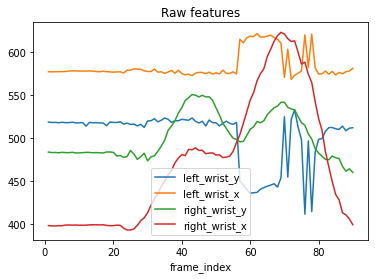

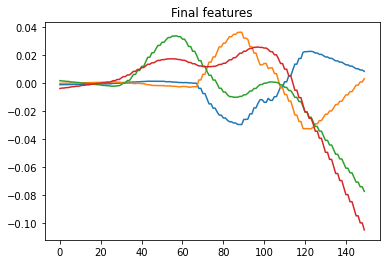

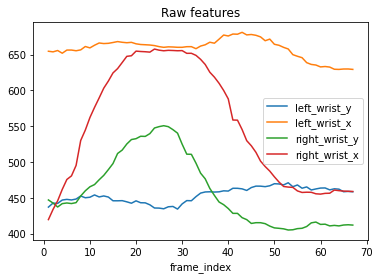

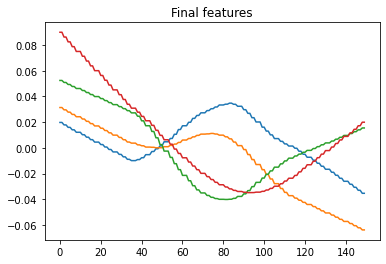

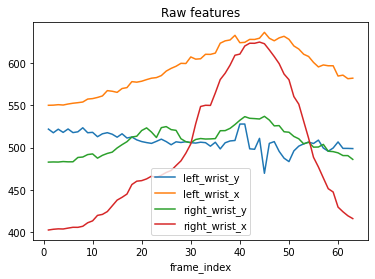

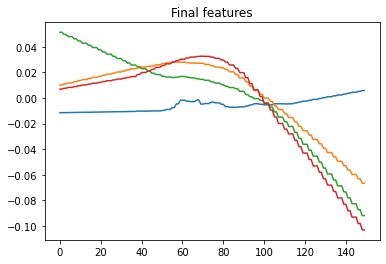

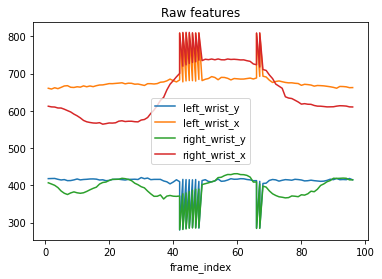

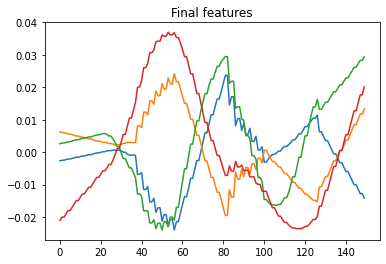

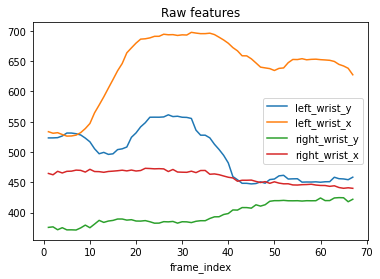

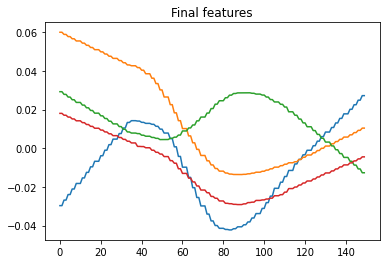

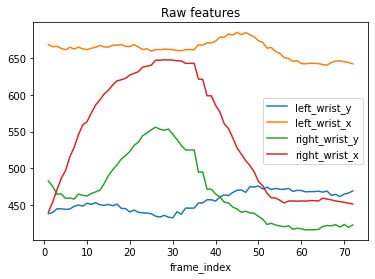

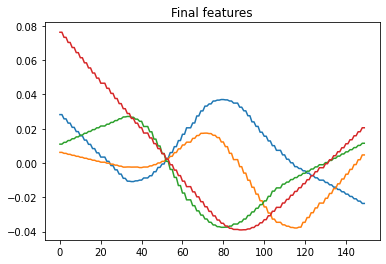

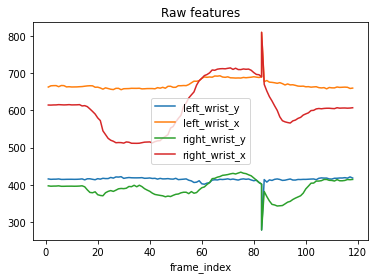

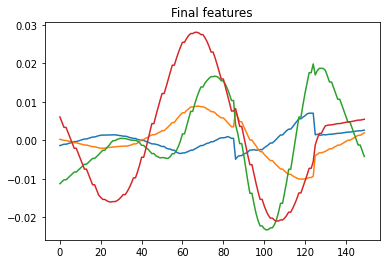

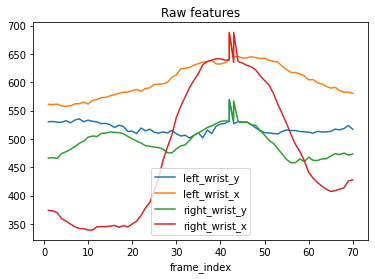

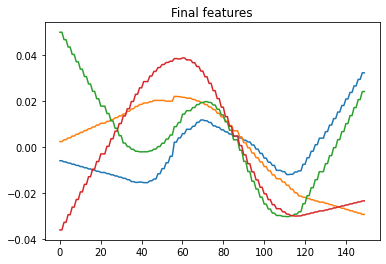

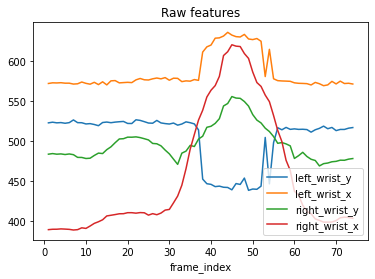

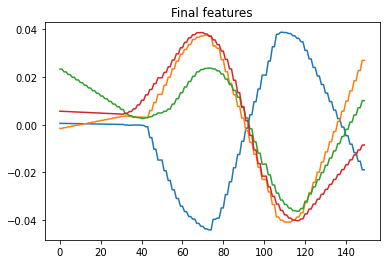

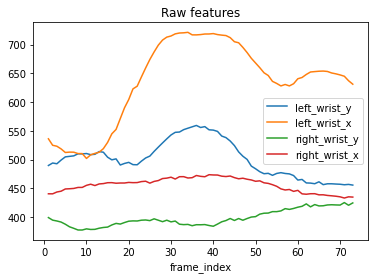

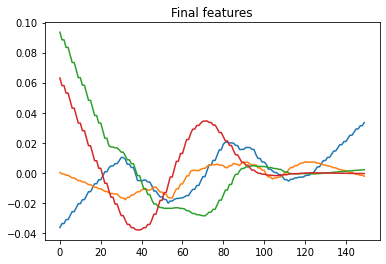

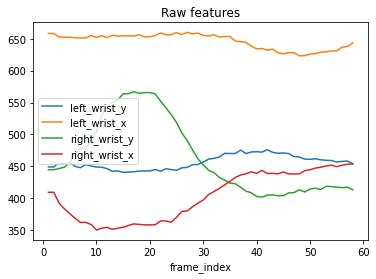

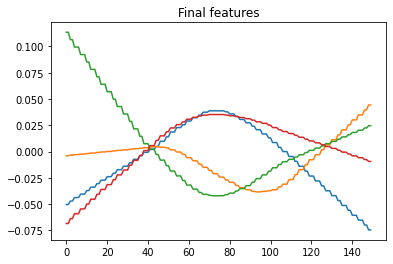

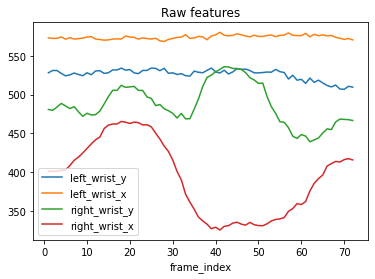

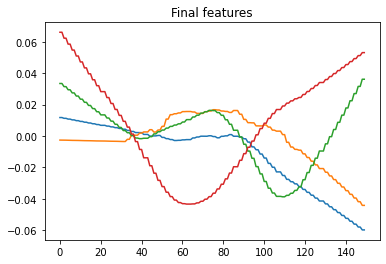

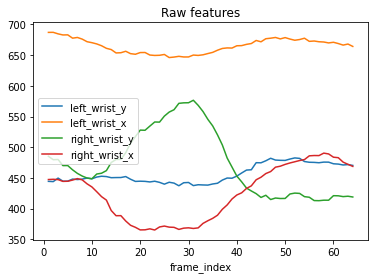

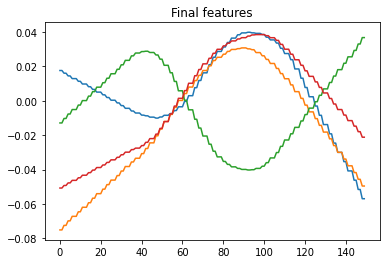

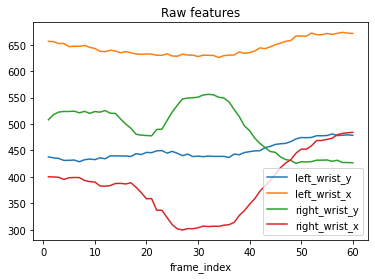

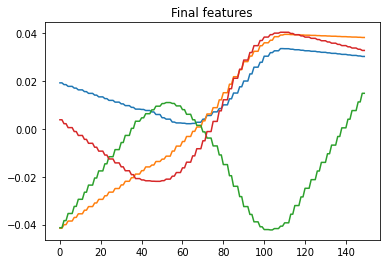

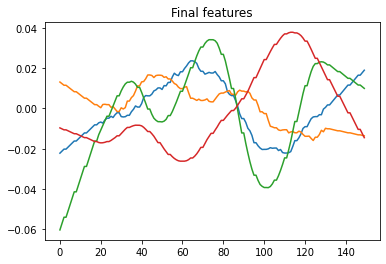

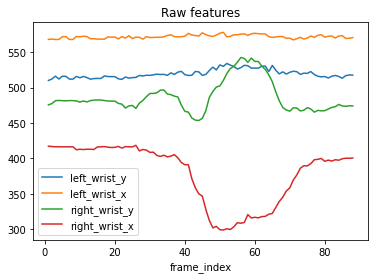

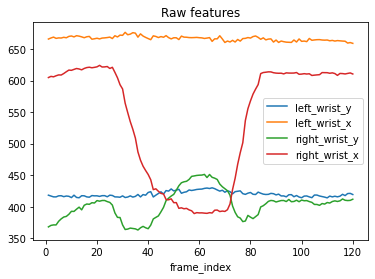

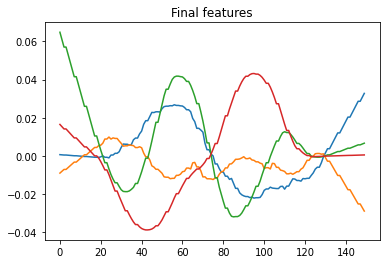

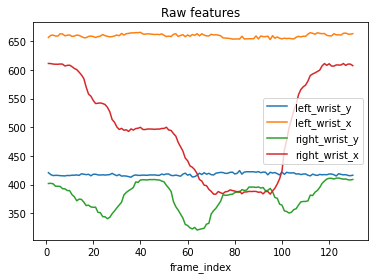

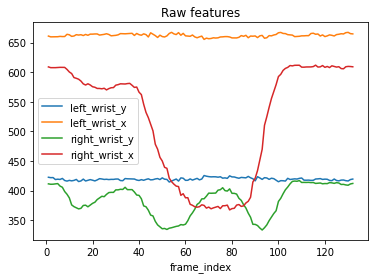

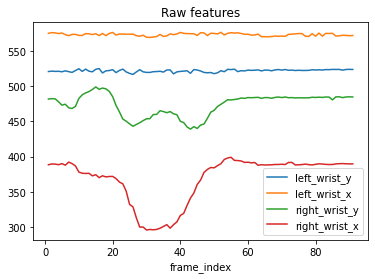

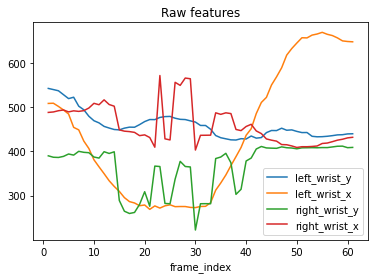

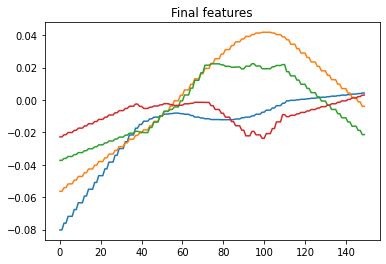

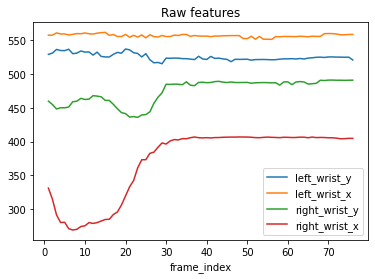

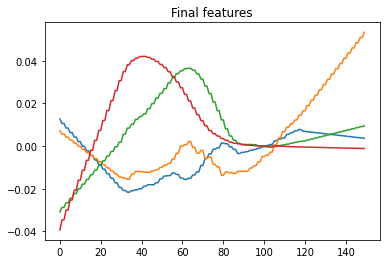

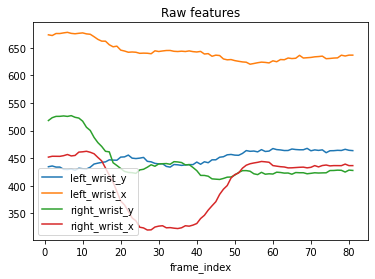

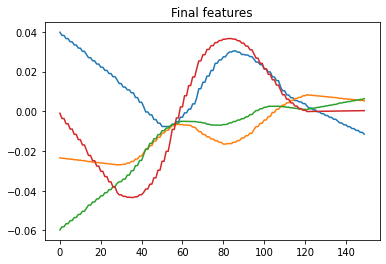

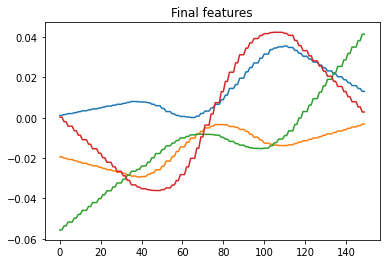

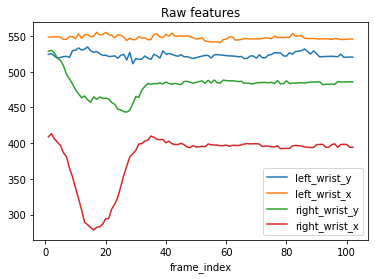

In [5]:
fe = ExtractFeatures(data_path, har_cfg_f)
X, Labels = fe.generate_features(draw_plots=True)


In [6]:
print(X.shape, np.unique(Labels))
print(np.unique(Labels))

(29, 150, 4) ['bananas' 'cucumbers' 'mandarins']
['bananas' 'cucumbers' 'mandarins']


In [7]:
# Mandarins moved to Right, Bananas moved to Left, Cucumbers moved to Front 

for ix, l in enumerate(Labels):
    if l == ['mandarins']:
        Labels[ix] = ['mandarins_right']
    elif l == ['bananas']:
        Labels[ix] = ['bananas_left']
    else:
        Labels[ix] = ['cucumbers_front']

In [8]:
print(X.shape, np.unique(Labels))

(29, 150, 4) ['bananas_left' 'cucumbers_front' 'mandarins_right']


In [9]:
# Labels
#Convert Labels to numerical labels
def label_encoder( text_labels):
    le = preprocessing.LabelEncoder()
    le.fit(np.unique(text_labels))
    return le

LE = label_encoder(Labels)
#Convert Labels to numerical labels
Y = LE.transform(Labels.ravel())

In [10]:
# Train-val, test split
#Create train, test and val sets
# Train-val, test split
#Create train, test and val sets
# X_train_all, X_test, y_train_all, y_test = train_test_split(X, Y, test_size=0.1, stratify=Y, random_state=1111)
# X_train, X_val, y_train, y_val = train_test_split(X_train_all, y_train_all, test_size=0.15, stratify=y_train_all, random_state=1111)
X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.10, stratify=Y, random_state=1111)

In [11]:
print(X_train.shape, X_val.shape)#, X_test.shape)#, X_train.dtype)

(26, 150, 4) (3, 150, 4)


In [12]:
print(X.shape)
# print(y_test)
print(y_val)

(29, 150, 4)
[2 0 1]


# 1.1 Convert dataset to Pytorch format
## Note that I am using trianing and test set, no validation set
## Also, no cross validation done [For later]

In [13]:
from common_utils.Dataset import Dataset

In [14]:
# for data, target in test_generator:
#     print(target)
#     break

# for data, target in training_generator:
#     print(data.shape, target.shape)
#     break

# 2. TCN Training and Testing

In [15]:
 
# Basically the receptive field is 
# kernel_size*last_value_of_dilation (assuming all powers of two).
# Also, if you want to cover the whole sequence you can consider 
# these parameters (for feature size 50): 

# dilations = [1, 2, 4, 8, 16, 32], kernel = 2
# dilations = [1, 2, 4, 8, 16, 32], kernel = 3
# dilations = [1, 2, 4, 8, 16], kernel = 5
# dilations = [1, 2, 4, 8], kernel = 7 #This should go to 32, but only 5 wavelengths are missing
# dilations = [1, 2, 4, 8], kernel = 9
# dilations = [1, 2, 4, 8], kernel = 11
# dilations = [1, 2, 4], kernel = 13
# dilations = [1, 2, 4], kernel = 15
# dilations = [1], kernel = 50


# That is, ksize=3, then levels = 6, for a feature vector of size 50
# That is, ksize=7, then levels = 4, for a feature vector of size 50
# That is, ksize=13, then levels = 3, for a feature vector of size 50

# these parameters (for feature size 150): 
# dilations = [1, 2, 4, 8, 16, 32, 64], kernel = 3
# dilations = [1, 2, 4, 8, 16, 32], kernel = 5
# dilations = [1, 2, 4, 8, 16], kernel = 10

# That is, ksize=5, then levels = 6, for a feature vector of size 150


In [16]:
#Best for now: 
#

#Variables

n_classes = np.unique(Labels).size
# batch_size = 1 # 

dropout = 0.1 #
clip = -1
# epochs = 2000 #
log_interval = 10
seed = 1111

input_channels = X_train.shape[2] #feature size (or  number of joint positions)
seq_length = X_train.shape[1] #This is the size of the temporal dimension
steps = 0
# train_loader = train
cuda=False
if torch.cuda.is_available():
    cuda = True

permute = False

# lr = 5e-5 
# wdecay = 1e-8

ksize = 5 #7 #13 #7 #
levels = 6 # 4 #3 #4 #
# num_channels_each_tcn_layer = 10 #OK....this is the number of channels per layer, not hidden units
# channel_sizes = [num_channels_each_tcn_layer] * levels #Defines the nubers of hidden layers



In [17]:
# model = TCN(input_channels, n_classes, channel_sizes, ksize, config["dropout"]).double()

# if cuda: 
#     model.to(torch.device('cuda'))
# else:
#     model.to(torch.device('cpu'))

# optimizer = optim.Adam(model.parameters(), config["weight_decay"], config["lr"])


In [18]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [19]:
#Assumes X_train and X_val are globally defined. Need to improve that
def train_tcn_hyp_param_tune(config, checkpoint_dir=None, data_dir=None):#, input_channels, n_classes, channle_sizes, dropoout):
    #model = TCN(input_channels, n_classes, channel_sizes, ksize, config["dropout"]).double()
    num_channels_each_tcn_layer = config['num_channels_each_tcn_layer']
    channel_sizes = [num_channels_each_tcn_layer] * levels #Defines the nubers of hidden layers

    model = TCN(input_channels, n_classes, channel_sizes, ksize, dropout).double()
    device = 'cpu'
    cuda=False
    if torch.cuda.is_available(): 
        device = 'cuda'
        cuda=True

    model.to(device)

    criterion = nn.CrossEntropyLoss()
#     optimizer = optim.Adam(model.parameters(), weight_decay=config["weight_decay"], lr=config["lr"])
    optimizer = optim.Adam(model.parameters(), lr=config["lr"])

    

#     if checkpoint_dir: Don't have yet
#         model_state, optimizer_state = torch.load(
#             os.path.join(checkpoint_dir, "checkpoint"))
#         net.load_state_dict(model_state)
#         optimizer.load_state_dict(optimizer_state)
    training_set = Dataset(data=X_train, labels=y_train)
    training_generator = DataLoader(training_set, batch_size=3, shuffle=True, num_workers=1)


    val_set = Dataset(data=X_val, labels=y_val)
    val_generator = DataLoader(val_set, batch_size=3, shuffle=True, num_workers=1)

    for epoch in range(config['max_num_epochs']):  # loop over the dataset multiple times
        running_loss = 0.0
        epoch_steps = 0
        
        train_loss = 0
        model.train()

        # Training
        for batch_idx, (data, target) in enumerate(training_generator):
            if cuda: 
                data, target = data.cuda(), target.cuda()
            target = target.unsqueeze(1)

            data = data.view(-1, input_channels, seq_length)
            data, target = Variable(data), Variable(target)

            optimizer.zero_grad()
            pred = model(data)
            
            loss_fn = nn.CrossEntropyLoss()
            loss = loss_fn(pred, target.long().squeeze(1)) #we have multi-class case here
            loss.backward()
    
            optimizer.step()
            running_loss += loss.item()
            epoch_steps += 1


            if batch_idx > 0 and batch_idx % log_interval == 0:
                print("[%d, %5d] loss: %.3f" % (epoch + 1, batch_idx + 1,
                                                running_loss / epoch_steps))

                running_loss = 0.0
            


        # Validation loss
        model.eval()
        val_loss = 0.0
        val_steps = 0
        total = 0
        correct = 0
        
        with torch.no_grad():
            for data, target in val_generator:
                if cuda:
                    data, target = data.cuda(), target.cuda()

                target = target.unsqueeze(1)

                data = data.view(-1, input_channels, seq_length)
                data, target = Variable(data), Variable(target)
                output = model(data.double())

                loss_fn = nn.CrossEntropyLoss()
                loss = loss_fn(output, target.long().squeeze(1)).item() #we have multi-class case here
#                 val_loss += loss.cpu().numpy()
                val_loss += loss

                
                pred = output.data.max(1, keepdim=True)[1]
                correct += pred.eq(target.data.view_as(pred)).cpu().sum()
                total += target.size(0)

                
                val_steps += 1
        
        with tune.checkpoint_dir(epoch) as checkpoint_dir:
            path = os.path.join(checkpoint_dir, "checkpoint")
            torch.save((model.state_dict(), optimizer.state_dict()), path)
        tune.report(loss=(val_loss / val_steps), accuracy=correct / total)

                
    print("Finished Training")

In [20]:
def main_run(num_samples=10, max_num_epochs=100, gpus_per_trial=1):
    data_dir = None
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    config = {
#     "weight_decay": tune.loguniform(1e-8, 1e-6),
#     "lr": tune.loguniform(1e-6, 1e-5),
    "max_num_epochs": tune.choice([100, 300, 500, 700, 900]),
    "lr": tune.choice([1e-6, 1e-5, 1e-4, 1e-3, 1e-2]),
    "num_channels_each_tcn_layer": tune.choice([5, 10, 15, 20, 25])  
#     "batch_size": tune.choice([2, 4, 8, 16])
    }
    scheduler = ASHAScheduler(
        metric="loss",
        mode="min",
        max_t=max_num_epochs,
        grace_period= int(max_num_epochs/4),
        reduction_factor=4)
    reporter = CLIReporter(
        # parameter_columns=["l1", "l2", "lr", "batch_size"],
        metric_columns=["loss", "accuracy", "training_iteration"])
    result = tune.run(
        partial(train_tcn_hyp_param_tune, data_dir=data_dir),
        resources_per_trial={"cpu": 2, "gpu": gpus_per_trial},
        config=config,
        num_samples=num_samples,
        scheduler=scheduler,
        progress_reporter=reporter)

    best_trial = result.get_best_trial("loss", "min", "last")
    print("Best trial config: {}".format(best_trial.config))
    print("Best trial final validation loss: {}".format(
        best_trial.last_result["loss"]))
    print("Best trial final validation accuracy: {}".format(
        best_trial.last_result["accuracy"]))

    return best_trial

    


In [21]:
#     test_acc = test_accuracy(best_trained_model, device) 
#     print("Best trial test set accuracy: {}".format(test_acc))


# if __name__ == "__main__":
#     # You can change the number of GPUs per trial here:
gpus_per_trial = 1
best_trial = main_run(num_samples=20, max_num_epochs=500, gpus_per_trial=1)
#main_run(num_samples=1, max_num_epochs=5, gpus_per_trial=1)
#Get the best model
best_num_channels_each_tcn_layer = best_trial.config['num_channels_each_tcn_layer']
best_channel_sizes = [best_num_channels_each_tcn_layer] * levels #Defines the nubers of hidden layers

best_trained_model = TCN(input_channels, n_classes, best_channel_sizes, ksize, dropout).double()



device = "cpu"
if torch.cuda.is_available():
    device = "cuda"
    if gpus_per_trial > 1:
        best_trained_model = nn.DataParallel(best_trained_model)
best_trained_model.to(device)

best_checkpoint_dir = best_trial.checkpoint.value
print(best_checkpoint_dir)
model_state, optimizer_state = torch.load(os.path.join(
    best_checkpoint_dir, "checkpoint"))
best_trained_model.load_state_dict(model_state)


2022-10-24 16:05:17,865	WARNING experiment.py:255 -- No name detected on trainable. Using DEFAULT.
2022-10-24 16:05:17,866	INFO registry.py:69 -- Detected unknown callable for trainable. Converting to class.


== Status ==
Current time: 2022-10-24 16:05:18 (running for 00:00:00.20)
Memory usage on this node: 5.2/31.2 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 500.000: None | Iter 125.000: None
Resources requested: 2.0/20 CPUs, 1.0/1 GPUs, 0.0/16.61 GiB heap, 0.0/8.3 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ur5/ray_results/DEFAULT_2022-10-24_16-05-17
Number of trials: 20/20 (19 PENDING, 1 RUNNING)
+---------------------+----------+-------------------+--------+------------------+-------------------------------+
| Trial name          | status   | loc               |     lr |   max_num_epochs |   num_channels_each_tcn_layer |
|---------------------+----------+-------------------+--------+------------------+-------------------------------|
| DEFAULT_e3bc7_00000 | RUNNING  | 10.72.9.72:675604 | 0.0001 |              700 |                            15 |
| DEFAULT_e3bc7_00001 | PENDING  |                   | 1e-06  |              900 |                            15 |

== Status ==
Current time: 2022-10-24 16:05:28 (running for 00:00:10.23)
Memory usage on this node: 7.4/31.2 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 500.000: None | Iter 125.000: None
Resources requested: 2.0/20 CPUs, 1.0/1 GPUs, 0.0/16.61 GiB heap, 0.0/8.3 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ur5/ray_results/DEFAULT_2022-10-24_16-05-17
Number of trials: 20/20 (19 PENDING, 1 RUNNING)
+---------------------+----------+-------------------+--------+------------------+-------------------------------+---------+------------+----------------------+
| Trial name          | status   | loc               |     lr |   max_num_epochs |   num_channels_each_tcn_layer |    loss |   accuracy |   training_iteration |
|---------------------+----------+-------------------+--------+------------------+-------------------------------+---------+------------+----------------------|
| DEFAULT_e3bc7_00000 | RUNNING  | 10.72.9.72:675604 | 0.0001 |              700 |         

Result for DEFAULT_e3bc7_00000:
  accuracy: tensor(0.3333)
  date: 2022-10-24_16-05-35
  done: false
  experiment_id: 06e53467b7d8460c857e4aa0352d5636
  hostname: ur5-desktop
  iterations_since_restore: 64
  loss: 1.1026478488853333
  node_ip: 10.72.9.72
  pid: 675604
  should_checkpoint: true
  time_since_restore: 17.0385000705719
  time_this_iter_s: 0.24144840240478516
  time_total_s: 17.0385000705719
  timestamp: 1666620335
  timesteps_since_restore: 0
  training_iteration: 64
  trial_id: e3bc7_00000
  
== Status ==
Current time: 2022-10-24 16:05:38 (running for 00:00:20.60)
Memory usage on this node: 7.4/31.2 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 500.000: None | Iter 125.000: None
Resources requested: 2.0/20 CPUs, 1.0/1 GPUs, 0.0/16.61 GiB heap, 0.0/8.3 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ur5/ray_results/DEFAULT_2022-10-24_16-05-17
Number of trials: 20/20 (19 PENDING, 1 RUNNING)
+---------------------+----------+-------------------+--------

Result for DEFAULT_e3bc7_00000:
  accuracy: tensor(0.3333)
  date: 2022-10-24_16-05-45
  done: false
  experiment_id: 06e53467b7d8460c857e4aa0352d5636
  hostname: ur5-desktop
  iterations_since_restore: 106
  loss: 1.1057137163906257
  node_ip: 10.72.9.72
  pid: 675604
  should_checkpoint: true
  time_since_restore: 27.194618701934814
  time_this_iter_s: 0.2505004405975342
  time_total_s: 27.194618701934814
  timestamp: 1666620345
  timesteps_since_restore: 0
  training_iteration: 106
  trial_id: e3bc7_00000
  
== Status ==
Current time: 2022-10-24 16:05:48 (running for 00:00:30.64)
Memory usage on this node: 7.4/31.2 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 500.000: None | Iter 125.000: None
Resources requested: 2.0/20 CPUs, 1.0/1 GPUs, 0.0/16.61 GiB heap, 0.0/8.3 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ur5/ray_results/DEFAULT_2022-10-24_16-05-17
Number of trials: 20/20 (19 PENDING, 1 RUNNING)
+---------------------+----------+-------------------+---

Result for DEFAULT_e3bc7_00000:
  accuracy: tensor(0.3333)
  date: 2022-10-24_16-05-56
  done: false
  experiment_id: 06e53467b7d8460c857e4aa0352d5636
  hostname: ur5-desktop
  iterations_since_restore: 148
  loss: 1.1045660093971792
  node_ip: 10.72.9.72
  pid: 675604
  should_checkpoint: true
  time_since_restore: 37.295427560806274
  time_this_iter_s: 0.23053860664367676
  time_total_s: 37.295427560806274
  timestamp: 1666620356
  timesteps_since_restore: 0
  training_iteration: 148
  trial_id: e3bc7_00000
  
== Status ==
Current time: 2022-10-24 16:05:58 (running for 00:00:40.97)
Memory usage on this node: 7.4/31.2 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 500.000: None | Iter 125.000: -1.106631363219767
Resources requested: 2.0/20 CPUs, 1.0/1 GPUs, 0.0/16.61 GiB heap, 0.0/8.3 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ur5/ray_results/DEFAULT_2022-10-24_16-05-17
Number of trials: 20/20 (19 PENDING, 1 RUNNING)
+---------------------+----------+--------

Result for DEFAULT_e3bc7_00000:
  accuracy: tensor(0.3333)
  date: 2022-10-24_16-06-06
  done: false
  experiment_id: 06e53467b7d8460c857e4aa0352d5636
  hostname: ur5-desktop
  iterations_since_restore: 192
  loss: 1.0913536714236594
  node_ip: 10.72.9.72
  pid: 675604
  should_checkpoint: true
  time_since_restore: 47.71790623664856
  time_this_iter_s: 0.22382116317749023
  time_total_s: 47.71790623664856
  timestamp: 1666620366
  timesteps_since_restore: 0
  training_iteration: 192
  trial_id: e3bc7_00000
  
== Status ==
Current time: 2022-10-24 16:06:09 (running for 00:00:51.19)
Memory usage on this node: 7.4/31.2 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 500.000: None | Iter 125.000: -1.106631363219767
Resources requested: 2.0/20 CPUs, 1.0/1 GPUs, 0.0/16.61 GiB heap, 0.0/8.3 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ur5/ray_results/DEFAULT_2022-10-24_16-05-17
Number of trials: 20/20 (19 PENDING, 1 RUNNING)
+---------------------+----------+----------

Result for DEFAULT_e3bc7_00000:
  accuracy: tensor(0.6667)
  date: 2022-10-24_16-06-16
  done: false
  experiment_id: 06e53467b7d8460c857e4aa0352d5636
  hostname: ur5-desktop
  iterations_since_restore: 235
  loss: 0.8911036740020061
  node_ip: 10.72.9.72
  pid: 675604
  should_checkpoint: true
  time_since_restore: 57.85253643989563
  time_this_iter_s: 0.23502302169799805
  time_total_s: 57.85253643989563
  timestamp: 1666620376
  timesteps_since_restore: 0
  training_iteration: 235
  trial_id: e3bc7_00000
  
== Status ==
Current time: 2022-10-24 16:06:19 (running for 00:01:01.56)
Memory usage on this node: 7.4/31.2 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 500.000: None | Iter 125.000: -1.106631363219767
Resources requested: 2.0/20 CPUs, 1.0/1 GPUs, 0.0/16.61 GiB heap, 0.0/8.3 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ur5/ray_results/DEFAULT_2022-10-24_16-05-17
Number of trials: 20/20 (19 PENDING, 1 RUNNING)
+---------------------+----------+----------

Result for DEFAULT_e3bc7_00000:
  accuracy: tensor(1.)
  date: 2022-10-24_16-06-26
  done: false
  experiment_id: 06e53467b7d8460c857e4aa0352d5636
  hostname: ur5-desktop
  iterations_since_restore: 278
  loss: 0.48826150323584855
  node_ip: 10.72.9.72
  pid: 675604
  should_checkpoint: true
  time_since_restore: 68.03479981422424
  time_this_iter_s: 0.23290300369262695
  time_total_s: 68.03479981422424
  timestamp: 1666620386
  timesteps_since_restore: 0
  training_iteration: 278
  trial_id: e3bc7_00000
  
== Status ==
Current time: 2022-10-24 16:06:29 (running for 00:01:11.77)
Memory usage on this node: 7.4/31.2 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 500.000: None | Iter 125.000: -1.106631363219767
Resources requested: 2.0/20 CPUs, 1.0/1 GPUs, 0.0/16.61 GiB heap, 0.0/8.3 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ur5/ray_results/DEFAULT_2022-10-24_16-05-17
Number of trials: 20/20 (19 PENDING, 1 RUNNING)
+---------------------+----------+-------------

Result for DEFAULT_e3bc7_00000:
  accuracy: tensor(1.)
  date: 2022-10-24_16-06-37
  done: false
  experiment_id: 06e53467b7d8460c857e4aa0352d5636
  hostname: ur5-desktop
  iterations_since_restore: 321
  loss: 0.4066672070603942
  node_ip: 10.72.9.72
  pid: 675604
  should_checkpoint: true
  time_since_restore: 78.28245306015015
  time_this_iter_s: 0.226393461227417
  time_total_s: 78.28245306015015
  timestamp: 1666620397
  timesteps_since_restore: 0
  training_iteration: 321
  trial_id: e3bc7_00000
  
== Status ==
Current time: 2022-10-24 16:06:40 (running for 00:01:22.17)
Memory usage on this node: 7.4/31.2 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 500.000: None | Iter 125.000: -1.106631363219767
Resources requested: 2.0/20 CPUs, 1.0/1 GPUs, 0.0/16.61 GiB heap, 0.0/8.3 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ur5/ray_results/DEFAULT_2022-10-24_16-05-17
Number of trials: 20/20 (19 PENDING, 1 RUNNING)
+---------------------+----------+----------------

Result for DEFAULT_e3bc7_00000:
  accuracy: tensor(0.6667)
  date: 2022-10-24_16-06-47
  done: false
  experiment_id: 06e53467b7d8460c857e4aa0352d5636
  hostname: ur5-desktop
  iterations_since_restore: 364
  loss: 0.41117753324991796
  node_ip: 10.72.9.72
  pid: 675604
  should_checkpoint: true
  time_since_restore: 88.52134299278259
  time_this_iter_s: 0.25179171562194824
  time_total_s: 88.52134299278259
  timestamp: 1666620407
  timesteps_since_restore: 0
  training_iteration: 364
  trial_id: e3bc7_00000
  
== Status ==
Current time: 2022-10-24 16:06:50 (running for 00:01:32.24)
Memory usage on this node: 7.4/31.2 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 500.000: None | Iter 125.000: -1.106631363219767
Resources requested: 2.0/20 CPUs, 1.0/1 GPUs, 0.0/16.61 GiB heap, 0.0/8.3 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ur5/ray_results/DEFAULT_2022-10-24_16-05-17
Number of trials: 20/20 (19 PENDING, 1 RUNNING)
+---------------------+----------+---------

Result for DEFAULT_e3bc7_00000:
  accuracy: tensor(1.)
  date: 2022-10-24_16-06-57
  done: false
  experiment_id: 06e53467b7d8460c857e4aa0352d5636
  hostname: ur5-desktop
  iterations_since_restore: 407
  loss: 0.3203482979551945
  node_ip: 10.72.9.72
  pid: 675604
  should_checkpoint: true
  time_since_restore: 98.75497460365295
  time_this_iter_s: 0.21480965614318848
  time_total_s: 98.75497460365295
  timestamp: 1666620417
  timesteps_since_restore: 0
  training_iteration: 407
  trial_id: e3bc7_00000
  
== Status ==
Current time: 2022-10-24 16:07:00 (running for 00:01:42.54)
Memory usage on this node: 7.4/31.2 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 500.000: None | Iter 125.000: -1.106631363219767
Resources requested: 2.0/20 CPUs, 1.0/1 GPUs, 0.0/16.61 GiB heap, 0.0/8.3 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ur5/ray_results/DEFAULT_2022-10-24_16-05-17
Number of trials: 20/20 (19 PENDING, 1 RUNNING)
+---------------------+----------+--------------

Result for DEFAULT_e3bc7_00000:
  accuracy: tensor(0.6667)
  date: 2022-10-24_16-07-07
  done: false
  experiment_id: 06e53467b7d8460c857e4aa0352d5636
  hostname: ur5-desktop
  iterations_since_restore: 449
  loss: 0.4566611022542935
  node_ip: 10.72.9.72
  pid: 675604
  should_checkpoint: true
  time_since_restore: 108.83157658576965
  time_this_iter_s: 0.23492002487182617
  time_total_s: 108.83157658576965
  timestamp: 1666620427
  timesteps_since_restore: 0
  training_iteration: 449
  trial_id: e3bc7_00000
  
== Status ==
Current time: 2022-10-24 16:07:10 (running for 00:01:53.00)
Memory usage on this node: 7.4/31.2 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 500.000: None | Iter 125.000: -1.106631363219767
Resources requested: 2.0/20 CPUs, 1.0/1 GPUs, 0.0/16.61 GiB heap, 0.0/8.3 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ur5/ray_results/DEFAULT_2022-10-24_16-05-17
Number of trials: 20/20 (19 PENDING, 1 RUNNING)
+---------------------+----------+--------

Result for DEFAULT_e3bc7_00000:
  accuracy: tensor(0.6667)
  date: 2022-10-24_16-07-17
  done: false
  experiment_id: 06e53467b7d8460c857e4aa0352d5636
  hostname: ur5-desktop
  iterations_since_restore: 492
  loss: 0.4217456748327449
  node_ip: 10.72.9.72
  pid: 675604
  should_checkpoint: true
  time_since_restore: 119.07308435440063
  time_this_iter_s: 0.23892831802368164
  time_total_s: 119.07308435440063
  timestamp: 1666620437
  timesteps_since_restore: 0
  training_iteration: 492
  trial_id: e3bc7_00000
  
Result for DEFAULT_e3bc7_00000:
  accuracy: tensor(1.)
  date: 2022-10-24_16-07-19
  done: true
  experiment_id: 06e53467b7d8460c857e4aa0352d5636
  hostname: ur5-desktop
  iterations_since_restore: 500
  loss: 0.25931706372176017
  node_ip: 10.72.9.72
  pid: 675604
  should_checkpoint: true
  time_since_restore: 120.98450779914856
  time_this_iter_s: 0.24112725257873535
  time_total_s: 120.98450779914856
  timestamp: 1666620439
  timesteps_since_restore: 0
  training_iteration:

Result for DEFAULT_e3bc7_00001:
  accuracy: tensor(0.3333)
  date: 2022-10-24_16-07-27
  done: false
  experiment_id: de8ceac15c7348b1a51543fbe8c6128c
  hostname: ur5-desktop
  iterations_since_restore: 22
  loss: 1.0993874292922323
  node_ip: 10.72.9.72
  pid: 675607
  should_checkpoint: true
  time_since_restore: 6.940664052963257
  time_this_iter_s: 0.24196267127990723
  time_total_s: 6.940664052963257
  timestamp: 1666620447
  timesteps_since_restore: 0
  training_iteration: 22
  trial_id: e3bc7_00001
  
== Status ==
Current time: 2022-10-24 16:07:31 (running for 00:02:13.99)
Memory usage on this node: 7.4/31.2 GiB
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 500.000: None | Iter 125.000: -1.106631363219767
Resources requested: 2.0/20 CPUs, 1.0/1 GPUs, 0.0/16.61 GiB heap, 0.0/8.3 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ur5/ray_results/DEFAULT_2022-10-24_16-05-17
Number of trials: 20/20 (18 PENDING, 1 RUNNING, 1 TERMINATED)
+---------------------+---------

Result for DEFAULT_e3bc7_00001:
  accuracy: tensor(0.3333)
  date: 2022-10-24_16-07-37
  done: false
  experiment_id: de8ceac15c7348b1a51543fbe8c6128c
  hostname: ur5-desktop
  iterations_since_restore: 64
  loss: 1.0994057095358254
  node_ip: 10.72.9.72
  pid: 675607
  should_checkpoint: true
  time_since_restore: 17.090630531311035
  time_this_iter_s: 0.23852777481079102
  time_total_s: 17.090630531311035
  timestamp: 1666620457
  timesteps_since_restore: 0
  training_iteration: 64
  trial_id: e3bc7_00001
  
== Status ==
Current time: 2022-10-24 16:07:42 (running for 00:02:24.12)
Memory usage on this node: 7.4/31.2 GiB
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 500.000: None | Iter 125.000: -1.106631363219767
Resources requested: 2.0/20 CPUs, 1.0/1 GPUs, 0.0/16.61 GiB heap, 0.0/8.3 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ur5/ray_results/DEFAULT_2022-10-24_16-05-17
Number of trials: 20/20 (18 PENDING, 1 RUNNING, 1 TERMINATED)
+---------------------+-------

Result for DEFAULT_e3bc7_00001:
  accuracy: tensor(0.3333)
  date: 2022-10-24_16-07-47
  done: false
  experiment_id: de8ceac15c7348b1a51543fbe8c6128c
  hostname: ur5-desktop
  iterations_since_restore: 106
  loss: 1.0994204407362573
  node_ip: 10.72.9.72
  pid: 675607
  should_checkpoint: true
  time_since_restore: 27.262510061264038
  time_this_iter_s: 0.23673319816589355
  time_total_s: 27.262510061264038
  timestamp: 1666620467
  timesteps_since_restore: 0
  training_iteration: 106
  trial_id: e3bc7_00001
  
== Status ==
Current time: 2022-10-24 16:07:52 (running for 00:02:34.49)
Memory usage on this node: 7.4/31.2 GiB
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 500.000: None | Iter 125.000: -1.101232023656373
Resources requested: 2.0/20 CPUs, 1.0/1 GPUs, 0.0/16.61 GiB heap, 0.0/8.3 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ur5/ray_results/DEFAULT_2022-10-24_16-05-17
Number of trials: 20/20 (18 PENDING, 1 RUNNING, 1 TERMINATED)
+---------------------+-----

Result for DEFAULT_e3bc7_00001:
  accuracy: tensor(0.3333)
  date: 2022-10-24_16-07-57
  done: false
  experiment_id: de8ceac15c7348b1a51543fbe8c6128c
  hostname: ur5-desktop
  iterations_since_restore: 148
  loss: 1.0994420153114037
  node_ip: 10.72.9.72
  pid: 675607
  should_checkpoint: true
  time_since_restore: 37.393012046813965
  time_this_iter_s: 0.2555058002471924
  time_total_s: 37.393012046813965
  timestamp: 1666620477
  timesteps_since_restore: 0
  training_iteration: 148
  trial_id: e3bc7_00001
  
== Status ==
Current time: 2022-10-24 16:08:02 (running for 00:02:44.65)
Memory usage on this node: 7.4/31.2 GiB
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 500.000: None | Iter 125.000: -1.101232023656373
Resources requested: 2.0/20 CPUs, 1.0/1 GPUs, 0.0/16.61 GiB heap, 0.0/8.3 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ur5/ray_results/DEFAULT_2022-10-24_16-05-17
Number of trials: 20/20 (18 PENDING, 1 RUNNING, 1 TERMINATED)
+---------------------+------

Result for DEFAULT_e3bc7_00001:
  accuracy: tensor(0.3333)
  date: 2022-10-24_16-08-07
  done: false
  experiment_id: de8ceac15c7348b1a51543fbe8c6128c
  hostname: ur5-desktop
  iterations_since_restore: 190
  loss: 1.0994871116477833
  node_ip: 10.72.9.72
  pid: 675607
  should_checkpoint: true
  time_since_restore: 47.596291065216064
  time_this_iter_s: 0.24403047561645508
  time_total_s: 47.596291065216064
  timestamp: 1666620487
  timesteps_since_restore: 0
  training_iteration: 190
  trial_id: e3bc7_00001
  
== Status ==
Current time: 2022-10-24 16:08:12 (running for 00:02:54.97)
Memory usage on this node: 7.4/31.2 GiB
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 500.000: None | Iter 125.000: -1.101232023656373
Resources requested: 2.0/20 CPUs, 1.0/1 GPUs, 0.0/16.61 GiB heap, 0.0/8.3 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ur5/ray_results/DEFAULT_2022-10-24_16-05-17
Number of trials: 20/20 (18 PENDING, 1 RUNNING, 1 TERMINATED)
+---------------------+-----

Result for DEFAULT_e3bc7_00001:
  accuracy: tensor(0.3333)
  date: 2022-10-24_16-08-18
  done: false
  experiment_id: de8ceac15c7348b1a51543fbe8c6128c
  hostname: ur5-desktop
  iterations_since_restore: 232
  loss: 1.0995043285875632
  node_ip: 10.72.9.72
  pid: 675607
  should_checkpoint: true
  time_since_restore: 57.873924255371094
  time_this_iter_s: 0.24588799476623535
  time_total_s: 57.873924255371094
  timestamp: 1666620498
  timesteps_since_restore: 0
  training_iteration: 232
  trial_id: e3bc7_00001
  
== Status ==
Current time: 2022-10-24 16:08:23 (running for 00:03:05.16)
Memory usage on this node: 7.4/31.2 GiB
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 500.000: None | Iter 125.000: -1.101232023656373
Resources requested: 2.0/20 CPUs, 1.0/1 GPUs, 0.0/16.61 GiB heap, 0.0/8.3 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ur5/ray_results/DEFAULT_2022-10-24_16-05-17
Number of trials: 20/20 (18 PENDING, 1 RUNNING, 1 TERMINATED)
+---------------------+-----

Result for DEFAULT_e3bc7_00001:
  accuracy: tensor(0.3333)
  date: 2022-10-24_16-08-28
  done: false
  experiment_id: de8ceac15c7348b1a51543fbe8c6128c
  hostname: ur5-desktop
  iterations_since_restore: 274
  loss: 1.0995376457365413
  node_ip: 10.72.9.72
  pid: 675607
  should_checkpoint: true
  time_since_restore: 68.08081078529358
  time_this_iter_s: 0.252302885055542
  time_total_s: 68.08081078529358
  timestamp: 1666620508
  timesteps_since_restore: 0
  training_iteration: 274
  trial_id: e3bc7_00001
  
== Status ==
Current time: 2022-10-24 16:08:33 (running for 00:03:15.33)
Memory usage on this node: 7.4/31.2 GiB
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 500.000: None | Iter 125.000: -1.101232023656373
Resources requested: 2.0/20 CPUs, 1.0/1 GPUs, 0.0/16.61 GiB heap, 0.0/8.3 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ur5/ray_results/DEFAULT_2022-10-24_16-05-17
Number of trials: 20/20 (18 PENDING, 1 RUNNING, 1 TERMINATED)
+---------------------+---------

Result for DEFAULT_e3bc7_00001:
  accuracy: tensor(0.3333)
  date: 2022-10-24_16-08-38
  done: false
  experiment_id: de8ceac15c7348b1a51543fbe8c6128c
  hostname: ur5-desktop
  iterations_since_restore: 316
  loss: 1.0995503386818348
  node_ip: 10.72.9.72
  pid: 675607
  should_checkpoint: true
  time_since_restore: 78.23508548736572
  time_this_iter_s: 0.23188352584838867
  time_total_s: 78.23508548736572
  timestamp: 1666620518
  timesteps_since_restore: 0
  training_iteration: 316
  trial_id: e3bc7_00001
  
== Status ==
Current time: 2022-10-24 16:08:43 (running for 00:03:25.62)
Memory usage on this node: 7.4/31.2 GiB
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 500.000: None | Iter 125.000: -1.101232023656373
Resources requested: 2.0/20 CPUs, 1.0/1 GPUs, 0.0/16.61 GiB heap, 0.0/8.3 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ur5/ray_results/DEFAULT_2022-10-24_16-05-17
Number of trials: 20/20 (18 PENDING, 1 RUNNING, 1 TERMINATED)
+---------------------+-------

Result for DEFAULT_e3bc7_00001:
  accuracy: tensor(0.3333)
  date: 2022-10-24_16-08-48
  done: false
  experiment_id: de8ceac15c7348b1a51543fbe8c6128c
  hostname: ur5-desktop
  iterations_since_restore: 358
  loss: 1.0995434574267586
  node_ip: 10.72.9.72
  pid: 675607
  should_checkpoint: true
  time_since_restore: 88.49286794662476
  time_this_iter_s: 0.23572611808776855
  time_total_s: 88.49286794662476
  timestamp: 1666620528
  timesteps_since_restore: 0
  training_iteration: 358
  trial_id: e3bc7_00001
  
== Status ==
Current time: 2022-10-24 16:08:53 (running for 00:03:35.73)
Memory usage on this node: 7.4/31.2 GiB
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 500.000: None | Iter 125.000: -1.101232023656373
Resources requested: 2.0/20 CPUs, 1.0/1 GPUs, 0.0/16.61 GiB heap, 0.0/8.3 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ur5/ray_results/DEFAULT_2022-10-24_16-05-17
Number of trials: 20/20 (18 PENDING, 1 RUNNING, 1 TERMINATED)
+---------------------+-------

Result for DEFAULT_e3bc7_00001:
  accuracy: tensor(0.3333)
  date: 2022-10-24_16-08-58
  done: false
  experiment_id: de8ceac15c7348b1a51543fbe8c6128c
  hostname: ur5-desktop
  iterations_since_restore: 400
  loss: 1.0995273033377864
  node_ip: 10.72.9.72
  pid: 675607
  should_checkpoint: true
  time_since_restore: 98.61518859863281
  time_this_iter_s: 0.2599220275878906
  time_total_s: 98.61518859863281
  timestamp: 1666620538
  timesteps_since_restore: 0
  training_iteration: 400
  trial_id: e3bc7_00001
  
== Status ==
Current time: 2022-10-24 16:09:03 (running for 00:03:45.92)
Memory usage on this node: 7.4/31.2 GiB
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 500.000: None | Iter 125.000: -1.101232023656373
Resources requested: 2.0/20 CPUs, 1.0/1 GPUs, 0.0/16.61 GiB heap, 0.0/8.3 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ur5/ray_results/DEFAULT_2022-10-24_16-05-17
Number of trials: 20/20 (18 PENDING, 1 RUNNING, 1 TERMINATED)
+---------------------+--------

Result for DEFAULT_e3bc7_00001:
  accuracy: tensor(0.3333)
  date: 2022-10-24_16-09-09
  done: false
  experiment_id: de8ceac15c7348b1a51543fbe8c6128c
  hostname: ur5-desktop
  iterations_since_restore: 442
  loss: 1.0995504582415345
  node_ip: 10.72.9.72
  pid: 675607
  should_checkpoint: true
  time_since_restore: 108.81728482246399
  time_this_iter_s: 0.24328398704528809
  time_total_s: 108.81728482246399
  timestamp: 1666620549
  timesteps_since_restore: 0
  training_iteration: 442
  trial_id: e3bc7_00001
  
== Status ==
Current time: 2022-10-24 16:09:14 (running for 00:03:56.15)
Memory usage on this node: 7.4/31.2 GiB
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 500.000: None | Iter 125.000: -1.101232023656373
Resources requested: 2.0/20 CPUs, 1.0/1 GPUs, 0.0/16.61 GiB heap, 0.0/8.3 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ur5/ray_results/DEFAULT_2022-10-24_16-05-17
Number of trials: 20/20 (18 PENDING, 1 RUNNING, 1 TERMINATED)
+---------------------+-----

Result for DEFAULT_e3bc7_00001:
  accuracy: tensor(0.3333)
  date: 2022-10-24_16-09-19
  done: false
  experiment_id: de8ceac15c7348b1a51543fbe8c6128c
  hostname: ur5-desktop
  iterations_since_restore: 484
  loss: 1.0995869056972218
  node_ip: 10.72.9.72
  pid: 675607
  should_checkpoint: true
  time_since_restore: 118.98240327835083
  time_this_iter_s: 0.23975872993469238
  time_total_s: 118.98240327835083
  timestamp: 1666620559
  timesteps_since_restore: 0
  training_iteration: 484
  trial_id: e3bc7_00001
  
Result for DEFAULT_e3bc7_00001:
  accuracy: tensor(0.3333)
  date: 2022-10-24_16-09-23
  done: true
  experiment_id: de8ceac15c7348b1a51543fbe8c6128c
  hostname: ur5-desktop
  iterations_since_restore: 500
  loss: 1.099598797572513
  node_ip: 10.72.9.72
  pid: 675607
  should_checkpoint: true
  time_since_restore: 122.94268870353699
  time_this_iter_s: 0.24599981307983398
  time_total_s: 122.94268870353699
  timestamp: 1666620563
  timesteps_since_restore: 0
  training_iteratio

Result for DEFAULT_e3bc7_00002:
  accuracy: tensor(0.3333)
  date: 2022-10-24_16-09-30
  done: false
  experiment_id: 672eebd343b74502be0533c27827c951
  hostname: ur5-desktop
  iterations_since_restore: 22
  loss: 1.0574954263941
  node_ip: 10.72.9.72
  pid: 675608
  should_checkpoint: true
  time_since_restore: 6.973715782165527
  time_this_iter_s: 0.239030122756958
  time_total_s: 6.973715782165527
  timestamp: 1666620570
  timesteps_since_restore: 0
  training_iteration: 22
  trial_id: e3bc7_00002
  
== Status ==
Current time: 2022-10-24 16:09:34 (running for 00:04:16.59)
Memory usage on this node: 7.3/31.2 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 500.000: None | Iter 125.000: -1.101232023656373
Resources requested: 2.0/20 CPUs, 1.0/1 GPUs, 0.0/16.61 GiB heap, 0.0/8.3 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ur5/ray_results/DEFAULT_2022-10-24_16-05-17
Number of trials: 20/20 (17 PENDING, 1 RUNNING, 2 TERMINATED)
+---------------------+------------+-

Result for DEFAULT_e3bc7_00002:
  accuracy: tensor(0.6667)
  date: 2022-10-24_16-09-41
  done: false
  experiment_id: 672eebd343b74502be0533c27827c951
  hostname: ur5-desktop
  iterations_since_restore: 63
  loss: 0.9173220626962663
  node_ip: 10.72.9.72
  pid: 675608
  should_checkpoint: true
  time_since_restore: 17.150986194610596
  time_this_iter_s: 0.2692677974700928
  time_total_s: 17.150986194610596
  timestamp: 1666620581
  timesteps_since_restore: 0
  training_iteration: 63
  trial_id: e3bc7_00002
  
== Status ==
Current time: 2022-10-24 16:09:44 (running for 00:04:26.92)
Memory usage on this node: 7.3/31.2 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 500.000: None | Iter 125.000: -1.101232023656373
Resources requested: 2.0/20 CPUs, 1.0/1 GPUs, 0.0/16.61 GiB heap, 0.0/8.3 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ur5/ray_results/DEFAULT_2022-10-24_16-05-17
Number of trials: 20/20 (17 PENDING, 1 RUNNING, 2 TERMINATED)
+---------------------+--------

Result for DEFAULT_e3bc7_00002:
  accuracy: tensor(0.6667)
  date: 2022-10-24_16-09-51
  done: false
  experiment_id: 672eebd343b74502be0533c27827c951
  hostname: ur5-desktop
  iterations_since_restore: 105
  loss: 1.0866841612986298
  node_ip: 10.72.9.72
  pid: 675608
  should_checkpoint: true
  time_since_restore: 27.438743591308594
  time_this_iter_s: 0.2729640007019043
  time_total_s: 27.438743591308594
  timestamp: 1666620591
  timesteps_since_restore: 0
  training_iteration: 105
  trial_id: e3bc7_00002
  
== Status ==
Current time: 2022-10-24 16:09:55 (running for 00:04:37.20)
Memory usage on this node: 7.3/31.2 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 500.000: None | Iter 125.000: -1.101232023656373
Resources requested: 2.0/20 CPUs, 1.0/1 GPUs, 0.0/16.61 GiB heap, 0.0/8.3 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ur5/ray_results/DEFAULT_2022-10-24_16-05-17
Number of trials: 20/20 (17 PENDING, 1 RUNNING, 2 TERMINATED)
+---------------------+------

Result for DEFAULT_e3bc7_00002:
  accuracy: tensor(0.3333)
  date: 2022-10-24_16-10-01
  done: false
  experiment_id: 672eebd343b74502be0533c27827c951
  hostname: ur5-desktop
  iterations_since_restore: 147
  loss: 1.0029995132438874
  node_ip: 10.72.9.72
  pid: 675608
  should_checkpoint: true
  time_since_restore: 37.74907064437866
  time_this_iter_s: 0.24478530883789062
  time_total_s: 37.74907064437866
  timestamp: 1666620601
  timesteps_since_restore: 0
  training_iteration: 147
  trial_id: e3bc7_00002
  
== Status ==
Current time: 2022-10-24 16:10:05 (running for 00:04:47.50)
Memory usage on this node: 7.3/31.2 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 500.000: None | Iter 125.000: -1.0655344954855124
Resources requested: 2.0/20 CPUs, 1.0/1 GPUs, 0.0/16.61 GiB heap, 0.0/8.3 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ur5/ray_results/DEFAULT_2022-10-24_16-05-17
Number of trials: 20/20 (17 PENDING, 1 RUNNING, 2 TERMINATED)
+---------------------+------

Result for DEFAULT_e3bc7_00002:
  accuracy: tensor(0.6667)
  date: 2022-10-24_16-10-11
  done: false
  experiment_id: 672eebd343b74502be0533c27827c951
  hostname: ur5-desktop
  iterations_since_restore: 189
  loss: 0.6505018965990478
  node_ip: 10.72.9.72
  pid: 675608
  should_checkpoint: true
  time_since_restore: 47.9964714050293
  time_this_iter_s: 0.23882365226745605
  time_total_s: 47.9964714050293
  timestamp: 1666620611
  timesteps_since_restore: 0
  training_iteration: 189
  trial_id: e3bc7_00002
  
== Status ==
Current time: 2022-10-24 16:10:15 (running for 00:04:57.71)
Memory usage on this node: 7.3/31.2 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 500.000: None | Iter 125.000: -1.0655344954855124
Resources requested: 2.0/20 CPUs, 1.0/1 GPUs, 0.0/16.61 GiB heap, 0.0/8.3 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ur5/ray_results/DEFAULT_2022-10-24_16-05-17
Number of trials: 20/20 (17 PENDING, 1 RUNNING, 2 TERMINATED)
+---------------------+--------

Result for DEFAULT_e3bc7_00002:
  accuracy: tensor(0.6667)
  date: 2022-10-24_16-10-22
  done: false
  experiment_id: 672eebd343b74502be0533c27827c951
  hostname: ur5-desktop
  iterations_since_restore: 231
  loss: 0.8527872139403772
  node_ip: 10.72.9.72
  pid: 675608
  should_checkpoint: true
  time_since_restore: 58.43365812301636
  time_this_iter_s: 0.24944710731506348
  time_total_s: 58.43365812301636
  timestamp: 1666620622
  timesteps_since_restore: 0
  training_iteration: 231
  trial_id: e3bc7_00002
  
== Status ==
Current time: 2022-10-24 16:10:25 (running for 00:05:07.93)
Memory usage on this node: 7.3/31.2 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 500.000: None | Iter 125.000: -1.0655344954855124
Resources requested: 2.0/20 CPUs, 1.0/1 GPUs, 0.0/16.61 GiB heap, 0.0/8.3 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ur5/ray_results/DEFAULT_2022-10-24_16-05-17
Number of trials: 20/20 (17 PENDING, 1 RUNNING, 2 TERMINATED)
+---------------------+------

Result for DEFAULT_e3bc7_00002:
  accuracy: tensor(0.6667)
  date: 2022-10-24_16-10-32
  done: false
  experiment_id: 672eebd343b74502be0533c27827c951
  hostname: ur5-desktop
  iterations_since_restore: 272
  loss: 0.4206813722813533
  node_ip: 10.72.9.72
  pid: 675608
  should_checkpoint: true
  time_since_restore: 68.65313839912415
  time_this_iter_s: 0.25031471252441406
  time_total_s: 68.65313839912415
  timestamp: 1666620632
  timesteps_since_restore: 0
  training_iteration: 272
  trial_id: e3bc7_00002
  
== Status ==
Current time: 2022-10-24 16:10:36 (running for 00:05:18.38)
Memory usage on this node: 7.3/31.2 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 500.000: None | Iter 125.000: -1.0655344954855124
Resources requested: 2.0/20 CPUs, 1.0/1 GPUs, 0.0/16.61 GiB heap, 0.0/8.3 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ur5/ray_results/DEFAULT_2022-10-24_16-05-17
Number of trials: 20/20 (17 PENDING, 1 RUNNING, 2 TERMINATED)
+---------------------+------

Result for DEFAULT_e3bc7_00003:
  accuracy: tensor(0.3333)
  date: 2022-10-24_16-10-41
  done: false
  experiment_id: 56b301481c134d59b3f090769a22fe11
  hostname: ur5-desktop
  iterations_since_restore: 1
  loss: 1.1058583122805574
  node_ip: 10.72.9.72
  pid: 675598
  should_checkpoint: true
  time_since_restore: 1.8048102855682373
  time_this_iter_s: 1.8048102855682373
  time_total_s: 1.8048102855682373
  timestamp: 1666620641
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: e3bc7_00003
  
== Status ==
Current time: 2022-10-24 16:10:46 (running for 00:05:28.72)
Memory usage on this node: 7.3/31.2 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 500.000: None | Iter 125.000: -1.0655344954855124
Resources requested: 2.0/20 CPUs, 1.0/1 GPUs, 0.0/16.61 GiB heap, 0.0/8.3 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ur5/ray_results/DEFAULT_2022-10-24_16-05-17
Number of trials: 20/20 (16 PENDING, 1 RUNNING, 3 TERMINATED)
+---------------------+---------

Result for DEFAULT_e3bc7_00003:
  accuracy: tensor(0.6667)
  date: 2022-10-24_16-10-52
  done: false
  experiment_id: 56b301481c134d59b3f090769a22fe11
  hostname: ur5-desktop
  iterations_since_restore: 43
  loss: 0.59447307665616
  node_ip: 10.72.9.72
  pid: 675598
  should_checkpoint: true
  time_since_restore: 12.08770203590393
  time_this_iter_s: 0.24505376815795898
  time_total_s: 12.08770203590393
  timestamp: 1666620652
  timesteps_since_restore: 0
  training_iteration: 43
  trial_id: e3bc7_00003
  
== Status ==
Current time: 2022-10-24 16:10:56 (running for 00:05:38.89)
Memory usage on this node: 7.3/31.2 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 500.000: None | Iter 125.000: -1.0655344954855124
Resources requested: 2.0/20 CPUs, 1.0/1 GPUs, 0.0/16.61 GiB heap, 0.0/8.3 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ur5/ray_results/DEFAULT_2022-10-24_16-05-17
Number of trials: 20/20 (16 PENDING, 1 RUNNING, 3 TERMINATED)
+---------------------+----------

Result for DEFAULT_e3bc7_00003:
  accuracy: tensor(1.)
  date: 2022-10-24_16-11-02
  done: false
  experiment_id: 56b301481c134d59b3f090769a22fe11
  hostname: ur5-desktop
  iterations_since_restore: 85
  loss: 0.2095828231198084
  node_ip: 10.72.9.72
  pid: 675598
  should_checkpoint: true
  time_since_restore: 22.182088136672974
  time_this_iter_s: 0.24064207077026367
  time_total_s: 22.182088136672974
  timestamp: 1666620662
  timesteps_since_restore: 0
  training_iteration: 85
  trial_id: e3bc7_00003
  
== Status ==
Current time: 2022-10-24 16:11:07 (running for 00:05:49.12)
Memory usage on this node: 7.3/31.2 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 500.000: None | Iter 125.000: -1.0655344954855124
Resources requested: 2.0/20 CPUs, 1.0/1 GPUs, 0.0/16.61 GiB heap, 0.0/8.3 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ur5/ray_results/DEFAULT_2022-10-24_16-05-17
Number of trials: 20/20 (16 PENDING, 1 RUNNING, 3 TERMINATED)
+---------------------+----------

Result for DEFAULT_e3bc7_00004:
  accuracy: tensor(0.3333)
  date: 2022-10-24_16-11-14
  done: false
  experiment_id: 0bab45064d544f62a98a960e1323863d
  hostname: ur5-desktop
  iterations_since_restore: 1
  loss: 1.1178827532551978
  node_ip: 10.72.9.72
  pid: 675609
  should_checkpoint: true
  time_since_restore: 1.7447843551635742
  time_this_iter_s: 1.7447843551635742
  time_total_s: 1.7447843551635742
  timestamp: 1666620674
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: e3bc7_00004
  
== Status ==
Current time: 2022-10-24 16:11:17 (running for 00:05:59.44)
Memory usage on this node: 7.2/31.2 GiB
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 500.000: None | Iter 125.000: -1.0824833696437104
Resources requested: 2.0/20 CPUs, 1.0/1 GPUs, 0.0/16.61 GiB heap, 0.0/8.3 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ur5/ray_results/DEFAULT_2022-10-24_16-05-17
Number of trials: 20/20 (15 PENDING, 1 RUNNING, 4 TERMINATED)
+---------------------+---------

Result for DEFAULT_e3bc7_00004:
  accuracy: tensor(0.3333)
  date: 2022-10-24_16-11-24
  done: false
  experiment_id: 0bab45064d544f62a98a960e1323863d
  hostname: ur5-desktop
  iterations_since_restore: 41
  loss: 1.1066079675305667
  node_ip: 10.72.9.72
  pid: 675609
  should_checkpoint: true
  time_since_restore: 11.850775480270386
  time_this_iter_s: 0.27242565155029297
  time_total_s: 11.850775480270386
  timestamp: 1666620684
  timesteps_since_restore: 0
  training_iteration: 41
  trial_id: e3bc7_00004
  
== Status ==
Current time: 2022-10-24 16:11:27 (running for 00:06:09.54)
Memory usage on this node: 7.2/31.2 GiB
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 500.000: None | Iter 125.000: -1.0824833696437104
Resources requested: 2.0/20 CPUs, 1.0/1 GPUs, 0.0/16.61 GiB heap, 0.0/8.3 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ur5/ray_results/DEFAULT_2022-10-24_16-05-17
Number of trials: 20/20 (15 PENDING, 1 RUNNING, 4 TERMINATED)
+---------------------+------

Result for DEFAULT_e3bc7_00004:
  accuracy: tensor(0.3333)
  date: 2022-10-24_16-11-34
  done: false
  experiment_id: 0bab45064d544f62a98a960e1323863d
  hostname: ur5-desktop
  iterations_since_restore: 82
  loss: 1.1095819158480194
  node_ip: 10.72.9.72
  pid: 675609
  should_checkpoint: true
  time_since_restore: 22.080311059951782
  time_this_iter_s: 0.24646401405334473
  time_total_s: 22.080311059951782
  timestamp: 1666620694
  timesteps_since_restore: 0
  training_iteration: 82
  trial_id: e3bc7_00004
  
== Status ==
Current time: 2022-10-24 16:11:37 (running for 00:06:19.97)
Memory usage on this node: 7.2/31.2 GiB
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 500.000: None | Iter 125.000: -1.0824833696437104
Resources requested: 2.0/20 CPUs, 1.0/1 GPUs, 0.0/16.61 GiB heap, 0.0/8.3 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ur5/ray_results/DEFAULT_2022-10-24_16-05-17
Number of trials: 20/20 (15 PENDING, 1 RUNNING, 4 TERMINATED)
+---------------------+------

Result for DEFAULT_e3bc7_00004:
  accuracy: tensor(0.3333)
  date: 2022-10-24_16-11-45
  done: false
  experiment_id: 0bab45064d544f62a98a960e1323863d
  hostname: ur5-desktop
  iterations_since_restore: 123
  loss: 1.1094837222832503
  node_ip: 10.72.9.72
  pid: 675609
  should_checkpoint: true
  time_since_restore: 32.34179735183716
  time_this_iter_s: 0.2456204891204834
  time_total_s: 32.34179735183716
  timestamp: 1666620705
  timesteps_since_restore: 0
  training_iteration: 123
  trial_id: e3bc7_00004
  
Result for DEFAULT_e3bc7_00004:
  accuracy: tensor(0.3333)
  date: 2022-10-24_16-11-45
  done: true
  experiment_id: 0bab45064d544f62a98a960e1323863d
  hostname: ur5-desktop
  iterations_since_restore: 125
  loss: 1.110143634086753
  node_ip: 10.72.9.72
  pid: 675609
  should_checkpoint: true
  time_since_restore: 32.85738205909729
  time_this_iter_s: 0.25068187713623047
  time_total_s: 32.85738205909729
  timestamp: 1666620705
  timesteps_since_restore: 0
  training_iteration: 12

Result for DEFAULT_e3bc7_00005:
  accuracy: tensor(0.3333)
  date: 2022-10-24_16-11-58
  done: false
  experiment_id: b451522faf6e49dda5058407217c47a3
  hostname: ur5-desktop
  iterations_since_restore: 41
  loss: 1.1090293081287548
  node_ip: 10.72.9.72
  pid: 675610
  should_checkpoint: true
  time_since_restore: 11.964676141738892
  time_this_iter_s: 0.2641019821166992
  time_total_s: 11.964676141738892
  timestamp: 1666620718
  timesteps_since_restore: 0
  training_iteration: 41
  trial_id: e3bc7_00005
  
== Status ==
Current time: 2022-10-24 16:11:58 (running for 00:06:40.38)
Memory usage on this node: 7.2/31.2 GiB
Using AsyncHyperBand: num_stopped=4
Bracket: Iter 500.000: None | Iter 125.000: -1.0994322438019084
Resources requested: 2.0/20 CPUs, 1.0/1 GPUs, 0.0/16.61 GiB heap, 0.0/8.3 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ur5/ray_results/DEFAULT_2022-10-24_16-05-17
Number of trials: 20/20 (14 PENDING, 1 RUNNING, 5 TERMINATED)
+---------------------+-------

Result for DEFAULT_e3bc7_00005:
  accuracy: tensor(0.3333)
  date: 2022-10-24_16-12-08
  done: false
  experiment_id: b451522faf6e49dda5058407217c47a3
  hostname: ur5-desktop
  iterations_since_restore: 81
  loss: 1.1077071285293858
  node_ip: 10.72.9.72
  pid: 675610
  should_checkpoint: true
  time_since_restore: 22.241750240325928
  time_this_iter_s: 0.25891923904418945
  time_total_s: 22.241750240325928
  timestamp: 1666620728
  timesteps_since_restore: 0
  training_iteration: 81
  trial_id: e3bc7_00005
  
== Status ==
Current time: 2022-10-24 16:12:08 (running for 00:06:50.66)
Memory usage on this node: 7.2/31.2 GiB
Using AsyncHyperBand: num_stopped=4
Bracket: Iter 500.000: None | Iter 125.000: -1.0994322438019084
Resources requested: 2.0/20 CPUs, 1.0/1 GPUs, 0.0/16.61 GiB heap, 0.0/8.3 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ur5/ray_results/DEFAULT_2022-10-24_16-05-17
Number of trials: 20/20 (14 PENDING, 1 RUNNING, 5 TERMINATED)
+---------------------+------

Result for DEFAULT_e3bc7_00005:
  accuracy: tensor(0.3333)
  date: 2022-10-24_16-12-18
  done: false
  experiment_id: b451522faf6e49dda5058407217c47a3
  hostname: ur5-desktop
  iterations_since_restore: 121
  loss: 1.1015105509257073
  node_ip: 10.72.9.72
  pid: 675610
  should_checkpoint: true
  time_since_restore: 32.30205488204956
  time_this_iter_s: 0.24769973754882812
  time_total_s: 32.30205488204956
  timestamp: 1666620738
  timesteps_since_restore: 0
  training_iteration: 121
  trial_id: e3bc7_00005
  
== Status ==
Current time: 2022-10-24 16:12:18 (running for 00:07:00.72)
Memory usage on this node: 7.2/31.2 GiB
Using AsyncHyperBand: num_stopped=4
Bracket: Iter 500.000: None | Iter 125.000: -1.0994322438019084
Resources requested: 2.0/20 CPUs, 1.0/1 GPUs, 0.0/16.61 GiB heap, 0.0/8.3 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ur5/ray_results/DEFAULT_2022-10-24_16-05-17
Number of trials: 20/20 (14 PENDING, 1 RUNNING, 5 TERMINATED)
+---------------------+------

Result for DEFAULT_e3bc7_00006:
  accuracy: tensor(0.3333)
  date: 2022-10-24_16-12-27
  done: false
  experiment_id: c30ec18c57ab4aebbbfa9abad86e5f9b
  hostname: ur5-desktop
  iterations_since_restore: 21
  loss: 1.0956880961999766
  node_ip: 10.72.9.72
  pid: 675603
  should_checkpoint: true
  time_since_restore: 6.907233715057373
  time_this_iter_s: 0.24771571159362793
  time_total_s: 6.907233715057373
  timestamp: 1666620747
  timesteps_since_restore: 0
  training_iteration: 21
  trial_id: e3bc7_00006
  
== Status ==
Current time: 2022-10-24 16:12:28 (running for 00:07:10.83)
Memory usage on this node: 7.1/31.2 GiB
Using AsyncHyperBand: num_stopped=5
Bracket: Iter 500.000: None | Iter 125.000: -1.0999733801465346
Resources requested: 2.0/20 CPUs, 1.0/1 GPUs, 0.0/16.61 GiB heap, 0.0/8.3 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ur5/ray_results/DEFAULT_2022-10-24_16-05-17
Number of trials: 20/20 (13 PENDING, 1 RUNNING, 6 TERMINATED)
+---------------------+--------

Result for DEFAULT_e3bc7_00006:
  accuracy: tensor(1.)
  date: 2022-10-24_16-12-37
  done: false
  experiment_id: c30ec18c57ab4aebbbfa9abad86e5f9b
  hostname: ur5-desktop
  iterations_since_restore: 62
  loss: 0.5052166794591886
  node_ip: 10.72.9.72
  pid: 675603
  should_checkpoint: true
  time_since_restore: 17.181006908416748
  time_this_iter_s: 0.2424335479736328
  time_total_s: 17.181006908416748
  timestamp: 1666620757
  timesteps_since_restore: 0
  training_iteration: 62
  trial_id: e3bc7_00006
  
== Status ==
Current time: 2022-10-24 16:12:39 (running for 00:07:21.14)
Memory usage on this node: 7.1/31.2 GiB
Using AsyncHyperBand: num_stopped=5
Bracket: Iter 500.000: None | Iter 125.000: -1.0999733801465346
Resources requested: 2.0/20 CPUs, 1.0/1 GPUs, 0.0/16.61 GiB heap, 0.0/8.3 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ur5/ray_results/DEFAULT_2022-10-24_16-05-17
Number of trials: 20/20 (13 PENDING, 1 RUNNING, 6 TERMINATED)
+---------------------+-----------

Result for DEFAULT_e3bc7_00006:
  accuracy: tensor(0.3333)
  date: 2022-10-24_16-12-47
  done: true
  experiment_id: c30ec18c57ab4aebbbfa9abad86e5f9b
  experiment_tag: 6_lr=0.01,max_num_epochs=100,num_channels_each_tcn_layer=25
  hostname: ur5-desktop
  iterations_since_restore: 100
  loss: 1.0936729024135114
  node_ip: 10.72.9.72
  pid: 675603
  should_checkpoint: true
  time_since_restore: 26.82291889190674
  time_this_iter_s: 0.25308680534362793
  time_total_s: 26.82291889190674
  timestamp: 1666620767
  timesteps_since_restore: 0
  training_iteration: 100
  trial_id: e3bc7_00006
  
(ImplicitFunc pid=675603) Finished Training
== Status ==
Current time: 2022-10-24 16:12:49 (running for 00:07:31.29)
Memory usage on this node: 6.9/31.2 GiB
Using AsyncHyperBand: num_stopped=5
Bracket: Iter 500.000: None | Iter 125.000: -1.0999733801465346
Resources requested: 2.0/20 CPUs, 1.0/1 GPUs, 0.0/16.61 GiB heap, 0.0/8.3 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ur5/ray_result

Result for DEFAULT_e3bc7_00007:
  accuracy: tensor(0.3333)
  date: 2022-10-24_16-12-54
  done: false
  experiment_id: 093d79e7589b4b6a98d0255b7bc6599a
  hostname: ur5-desktop
  iterations_since_restore: 21
  loss: 1.1103991563081068
  node_ip: 10.72.9.72
  pid: 675601
  should_checkpoint: true
  time_since_restore: 6.878837585449219
  time_this_iter_s: 0.28466081619262695
  time_total_s: 6.878837585449219
  timestamp: 1666620774
  timesteps_since_restore: 0
  training_iteration: 21
  trial_id: e3bc7_00007
  
== Status ==
Current time: 2022-10-24 16:12:59 (running for 00:07:41.57)
Memory usage on this node: 7.1/31.2 GiB
Using AsyncHyperBand: num_stopped=5
Bracket: Iter 500.000: None | Iter 125.000: -1.0999733801465346
Resources requested: 2.0/20 CPUs, 1.0/1 GPUs, 0.0/16.61 GiB heap, 0.0/8.3 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ur5/ray_results/DEFAULT_2022-10-24_16-05-17
Number of trials: 20/20 (12 PENDING, 1 RUNNING, 7 TERMINATED)
+---------------------+--------

Result for DEFAULT_e3bc7_00007:
  accuracy: tensor(0.3333)
  date: 2022-10-24_16-13-04
  done: false
  experiment_id: 093d79e7589b4b6a98d0255b7bc6599a
  hostname: ur5-desktop
  iterations_since_restore: 61
  loss: 1.340332512638797
  node_ip: 10.72.9.72
  pid: 675601
  should_checkpoint: true
  time_since_restore: 16.951680183410645
  time_this_iter_s: 0.2803208827972412
  time_total_s: 16.951680183410645
  timestamp: 1666620784
  timesteps_since_restore: 0
  training_iteration: 61
  trial_id: e3bc7_00007
  
== Status ==
Current time: 2022-10-24 16:13:09 (running for 00:07:51.80)
Memory usage on this node: 7.0/31.2 GiB
Using AsyncHyperBand: num_stopped=5
Bracket: Iter 500.000: None | Iter 125.000: -1.0999733801465346
Resources requested: 2.0/20 CPUs, 1.0/1 GPUs, 0.0/16.61 GiB heap, 0.0/8.3 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ur5/ray_results/DEFAULT_2022-10-24_16-05-17
Number of trials: 20/20 (12 PENDING, 1 RUNNING, 7 TERMINATED)
+---------------------+--------

Result for DEFAULT_e3bc7_00007:
  accuracy: tensor(0.3333)
  date: 2022-10-24_16-13-15
  done: false
  experiment_id: 093d79e7589b4b6a98d0255b7bc6599a
  hostname: ur5-desktop
  iterations_since_restore: 103
  loss: 2.0162448046669152
  node_ip: 10.72.9.72
  pid: 675601
  should_checkpoint: true
  time_since_restore: 27.323537588119507
  time_this_iter_s: 0.24808049201965332
  time_total_s: 27.323537588119507
  timestamp: 1666620795
  timesteps_since_restore: 0
  training_iteration: 103
  trial_id: e3bc7_00007
  
== Status ==
Current time: 2022-10-24 16:13:20 (running for 00:08:02.21)
Memory usage on this node: 7.0/31.2 GiB
Using AsyncHyperBand: num_stopped=5
Bracket: Iter 500.000: None | Iter 125.000: -1.0999733801465346
Resources requested: 2.0/20 CPUs, 1.0/1 GPUs, 0.0/16.61 GiB heap, 0.0/8.3 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ur5/ray_results/DEFAULT_2022-10-24_16-05-17
Number of trials: 20/20 (12 PENDING, 1 RUNNING, 7 TERMINATED)
+---------------------+----

Result for DEFAULT_e3bc7_00008:
  accuracy: tensor(0.3333)
  date: 2022-10-24_16-13-28
  done: false
  experiment_id: a0d2013a9cbc4b34861ea4cb3687d632
  hostname: ur5-desktop
  iterations_since_restore: 21
  loss: 1.1256579442766523
  node_ip: 10.72.9.72
  pid: 675602
  should_checkpoint: true
  time_since_restore: 6.94601583480835
  time_this_iter_s: 0.2473158836364746
  time_total_s: 6.94601583480835
  timestamp: 1666620808
  timesteps_since_restore: 0
  training_iteration: 21
  trial_id: e3bc7_00008
  
== Status ==
Current time: 2022-10-24 16:13:30 (running for 00:08:12.60)
Memory usage on this node: 7.0/31.2 GiB
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 500.000: None | Iter 125.000: -1.100514516491161
Resources requested: 2.0/20 CPUs, 1.0/1 GPUs, 0.0/16.61 GiB heap, 0.0/8.3 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ur5/ray_results/DEFAULT_2022-10-24_16-05-17
Number of trials: 20/20 (11 PENDING, 1 RUNNING, 8 TERMINATED)
+---------------------+------------

Result for DEFAULT_e3bc7_00008:
  accuracy: tensor(0.3333)
  date: 2022-10-24_16-13-38
  done: false
  experiment_id: a0d2013a9cbc4b34861ea4cb3687d632
  hostname: ur5-desktop
  iterations_since_restore: 61
  loss: 1.1199760798500151
  node_ip: 10.72.9.72
  pid: 675602
  should_checkpoint: true
  time_since_restore: 17.272428035736084
  time_this_iter_s: 0.2608962059020996
  time_total_s: 17.272428035736084
  timestamp: 1666620818
  timesteps_since_restore: 0
  training_iteration: 61
  trial_id: e3bc7_00008
  
== Status ==
Current time: 2022-10-24 16:13:40 (running for 00:08:22.87)
Memory usage on this node: 7.0/31.2 GiB
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 500.000: None | Iter 125.000: -1.100514516491161
Resources requested: 2.0/20 CPUs, 1.0/1 GPUs, 0.0/16.61 GiB heap, 0.0/8.3 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ur5/ray_results/DEFAULT_2022-10-24_16-05-17
Number of trials: 20/20 (11 PENDING, 1 RUNNING, 8 TERMINATED)
+---------------------+--------

Result for DEFAULT_e3bc7_00008:
  accuracy: tensor(0.3333)
  date: 2022-10-24_16-13-48
  done: false
  experiment_id: a0d2013a9cbc4b34861ea4cb3687d632
  hostname: ur5-desktop
  iterations_since_restore: 101
  loss: 1.1153282559604603
  node_ip: 10.72.9.72
  pid: 675602
  should_checkpoint: true
  time_since_restore: 27.478089809417725
  time_this_iter_s: 0.251267671585083
  time_total_s: 27.478089809417725
  timestamp: 1666620828
  timesteps_since_restore: 0
  training_iteration: 101
  trial_id: e3bc7_00008
  
== Status ==
Current time: 2022-10-24 16:13:51 (running for 00:08:33.11)
Memory usage on this node: 7.0/31.2 GiB
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 500.000: None | Iter 125.000: -1.100514516491161
Resources requested: 2.0/20 CPUs, 1.0/1 GPUs, 0.0/16.61 GiB heap, 0.0/8.3 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ur5/ray_results/DEFAULT_2022-10-24_16-05-17
Number of trials: 20/20 (11 PENDING, 1 RUNNING, 8 TERMINATED)
+---------------------+-------

Result for DEFAULT_e3bc7_00009:
  accuracy: tensor(0.3333)
  date: 2022-10-24_16-13-57
  done: false
  experiment_id: 9e5d0d298e74459691726d12257535d8
  hostname: ur5-desktop
  iterations_since_restore: 1
  loss: 1.1023744035217033
  node_ip: 10.72.9.72
  pid: 675600
  should_checkpoint: true
  time_since_restore: 1.8447163105010986
  time_this_iter_s: 1.8447163105010986
  time_total_s: 1.8447163105010986
  timestamp: 1666620837
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: e3bc7_00009
  
== Status ==
Current time: 2022-10-24 16:14:02 (running for 00:08:44.11)
Memory usage on this node: 6.9/31.2 GiB
Using AsyncHyperBand: num_stopped=7
Bracket: Iter 500.000: None | Iter 125.000: -1.1010556528357873
Resources requested: 2.0/20 CPUs, 1.0/1 GPUs, 0.0/16.61 GiB heap, 0.0/8.3 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ur5/ray_results/DEFAULT_2022-10-24_16-05-17
Number of trials: 20/20 (10 PENDING, 1 RUNNING, 9 TERMINATED)
+---------------------+---------

Result for DEFAULT_e3bc7_00009:
  accuracy: tensor(0.3333)
  date: 2022-10-24_16-14-07
  done: false
  experiment_id: 9e5d0d298e74459691726d12257535d8
  hostname: ur5-desktop
  iterations_since_restore: 41
  loss: 1.1022056272524405
  node_ip: 10.72.9.72
  pid: 675600
  should_checkpoint: true
  time_since_restore: 12.286635160446167
  time_this_iter_s: 0.2608835697174072
  time_total_s: 12.286635160446167
  timestamp: 1666620847
  timesteps_since_restore: 0
  training_iteration: 41
  trial_id: e3bc7_00009
  
== Status ==
Current time: 2022-10-24 16:14:12 (running for 00:08:54.44)
Memory usage on this node: 6.9/31.2 GiB
Using AsyncHyperBand: num_stopped=7
Bracket: Iter 500.000: None | Iter 125.000: -1.1010556528357873
Resources requested: 2.0/20 CPUs, 1.0/1 GPUs, 0.0/16.61 GiB heap, 0.0/8.3 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ur5/ray_results/DEFAULT_2022-10-24_16-05-17
Number of trials: 20/20 (10 PENDING, 1 RUNNING, 9 TERMINATED)
+---------------------+-------

Result for DEFAULT_e3bc7_00009:
  accuracy: tensor(0.3333)
  date: 2022-10-24_16-14-17
  done: false
  experiment_id: 9e5d0d298e74459691726d12257535d8
  hostname: ur5-desktop
  iterations_since_restore: 81
  loss: 1.1020476855054244
  node_ip: 10.72.9.72
  pid: 675600
  should_checkpoint: true
  time_since_restore: 22.442846536636353
  time_this_iter_s: 0.24755191802978516
  time_total_s: 22.442846536636353
  timestamp: 1666620857
  timesteps_since_restore: 0
  training_iteration: 81
  trial_id: e3bc7_00009
  
== Status ==
Current time: 2022-10-24 16:14:22 (running for 00:09:04.53)
Memory usage on this node: 6.9/31.2 GiB
Using AsyncHyperBand: num_stopped=7
Bracket: Iter 500.000: None | Iter 125.000: -1.1010556528357873
Resources requested: 2.0/20 CPUs, 1.0/1 GPUs, 0.0/16.61 GiB heap, 0.0/8.3 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ur5/ray_results/DEFAULT_2022-10-24_16-05-17
Number of trials: 20/20 (10 PENDING, 1 RUNNING, 9 TERMINATED)
+---------------------+------

Result for DEFAULT_e3bc7_00009:
  accuracy: tensor(0.3333)
  date: 2022-10-24_16-14-28
  done: false
  experiment_id: 9e5d0d298e74459691726d12257535d8
  hostname: ur5-desktop
  iterations_since_restore: 121
  loss: 1.1019113050330545
  node_ip: 10.72.9.72
  pid: 675600
  should_checkpoint: true
  time_since_restore: 32.74941325187683
  time_this_iter_s: 0.26955628395080566
  time_total_s: 32.74941325187683
  timestamp: 1666620868
  timesteps_since_restore: 0
  training_iteration: 121
  trial_id: e3bc7_00009
  
Result for DEFAULT_e3bc7_00009:
  accuracy: tensor(0.3333)
  date: 2022-10-24_16-14-29
  done: true
  experiment_id: 9e5d0d298e74459691726d12257535d8
  hostname: ur5-desktop
  iterations_since_restore: 125
  loss: 1.1018964243441065
  node_ip: 10.72.9.72
  pid: 675600
  should_checkpoint: true
  time_since_restore: 33.81601285934448
  time_this_iter_s: 0.2568960189819336
  time_total_s: 33.81601285934448
  timestamp: 1666620869
  timesteps_since_restore: 0
  training_iteration: 1

Result for DEFAULT_e3bc7_00010:
  accuracy: tensor(0.6667)
  date: 2022-10-24_16-14-41
  done: false
  experiment_id: c8ae1ae9cc704644ab2e45399680e1ea
  hostname: ur5-desktop
  iterations_since_restore: 39
  loss: 0.509862372218446
  node_ip: 10.72.9.72
  pid: 675594
  should_checkpoint: true
  time_since_restore: 11.951286792755127
  time_this_iter_s: 0.2480146884918213
  time_total_s: 11.951286792755127
  timestamp: 1666620881
  timesteps_since_restore: 0
  training_iteration: 39
  trial_id: e3bc7_00010
  
== Status ==
Current time: 2022-10-24 16:14:42 (running for 00:09:25.04)
Memory usage on this node: 6.9/31.2 GiB
Using AsyncHyperBand: num_stopped=8
Bracket: Iter 500.000: None | Iter 125.000: -1.1015967891804135
Resources requested: 2.0/20 CPUs, 1.0/1 GPUs, 0.0/16.61 GiB heap, 0.0/8.3 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ur5/ray_results/DEFAULT_2022-10-24_16-05-17
Number of trials: 20/20 (9 PENDING, 1 RUNNING, 10 TERMINATED)
+---------------------+--------

Result for DEFAULT_e3bc7_00010:
  accuracy: tensor(0.6667)
  date: 2022-10-24_16-14-52
  done: false
  experiment_id: c8ae1ae9cc704644ab2e45399680e1ea
  hostname: ur5-desktop
  iterations_since_restore: 78
  loss: 0.4856343259284876
  node_ip: 10.72.9.72
  pid: 675594
  should_checkpoint: true
  time_since_restore: 22.077835083007812
  time_this_iter_s: 0.2639811038970947
  time_total_s: 22.077835083007812
  timestamp: 1666620892
  timesteps_since_restore: 0
  training_iteration: 78
  trial_id: e3bc7_00010
  
== Status ==
Current time: 2022-10-24 16:14:53 (running for 00:09:35.16)
Memory usage on this node: 6.9/31.2 GiB
Using AsyncHyperBand: num_stopped=8
Bracket: Iter 500.000: None | Iter 125.000: -1.1015967891804135
Resources requested: 2.0/20 CPUs, 1.0/1 GPUs, 0.0/16.61 GiB heap, 0.0/8.3 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ur5/ray_results/DEFAULT_2022-10-24_16-05-17
Number of trials: 20/20 (9 PENDING, 1 RUNNING, 10 TERMINATED)
+---------------------+-------

Result for DEFAULT_e3bc7_00010:
  accuracy: tensor(0.6667)
  date: 2022-10-24_16-15-02
  done: false
  experiment_id: c8ae1ae9cc704644ab2e45399680e1ea
  hostname: ur5-desktop
  iterations_since_restore: 117
  loss: 0.5301199084894502
  node_ip: 10.72.9.72
  pid: 675594
  should_checkpoint: true
  time_since_restore: 32.37234663963318
  time_this_iter_s: 0.257033109664917
  time_total_s: 32.37234663963318
  timestamp: 1666620902
  timesteps_since_restore: 0
  training_iteration: 117
  trial_id: e3bc7_00010
  
== Status ==
Current time: 2022-10-24 16:15:03 (running for 00:09:45.52)
Memory usage on this node: 6.9/31.2 GiB
Using AsyncHyperBand: num_stopped=8
Bracket: Iter 500.000: None | Iter 125.000: -1.1015967891804135
Resources requested: 2.0/20 CPUs, 1.0/1 GPUs, 0.0/16.61 GiB heap, 0.0/8.3 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ur5/ray_results/DEFAULT_2022-10-24_16-05-17
Number of trials: 20/20 (9 PENDING, 1 RUNNING, 10 TERMINATED)
+---------------------+--------

Result for DEFAULT_e3bc7_00010:
  accuracy: tensor(0.6667)
  date: 2022-10-24_16-15-12
  done: false
  experiment_id: c8ae1ae9cc704644ab2e45399680e1ea
  hostname: ur5-desktop
  iterations_since_restore: 156
  loss: 2.4134420862205053
  node_ip: 10.72.9.72
  pid: 675594
  should_checkpoint: true
  time_since_restore: 42.75003623962402
  time_this_iter_s: 0.27949976921081543
  time_total_s: 42.75003623962402
  timestamp: 1666620912
  timesteps_since_restore: 0
  training_iteration: 156
  trial_id: e3bc7_00010
  
== Status ==
Current time: 2022-10-24 16:15:13 (running for 00:09:55.86)
Memory usage on this node: 6.9/31.2 GiB
Using AsyncHyperBand: num_stopped=8
Bracket: Iter 500.000: None | Iter 125.000: -1.0999733801465346
Resources requested: 2.0/20 CPUs, 1.0/1 GPUs, 0.0/16.61 GiB heap, 0.0/8.3 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ur5/ray_results/DEFAULT_2022-10-24_16-05-17
Number of trials: 20/20 (9 PENDING, 1 RUNNING, 10 TERMINATED)
+---------------------+------

Result for DEFAULT_e3bc7_00010:
  accuracy: tensor(0.6667)
  date: 2022-10-24_16-15-22
  done: false
  experiment_id: c8ae1ae9cc704644ab2e45399680e1ea
  hostname: ur5-desktop
  iterations_since_restore: 194
  loss: 2.8416078965776657
  node_ip: 10.72.9.72
  pid: 675594
  should_checkpoint: true
  time_since_restore: 52.92717528343201
  time_this_iter_s: 0.2543025016784668
  time_total_s: 52.92717528343201
  timestamp: 1666620922
  timesteps_since_restore: 0
  training_iteration: 194
  trial_id: e3bc7_00010
  
== Status ==
Current time: 2022-10-24 16:15:23 (running for 00:10:06.04)
Memory usage on this node: 6.9/31.2 GiB
Using AsyncHyperBand: num_stopped=8
Bracket: Iter 500.000: None | Iter 125.000: -1.0999733801465346
Resources requested: 2.0/20 CPUs, 1.0/1 GPUs, 0.0/16.61 GiB heap, 0.0/8.3 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ur5/ray_results/DEFAULT_2022-10-24_16-05-17
Number of trials: 20/20 (9 PENDING, 1 RUNNING, 10 TERMINATED)
+---------------------+-------

Result for DEFAULT_e3bc7_00010:
  accuracy: tensor(0.6667)
  date: 2022-10-24_16-15-33
  done: false
  experiment_id: c8ae1ae9cc704644ab2e45399680e1ea
  hostname: ur5-desktop
  iterations_since_restore: 234
  loss: 4.917078441845152
  node_ip: 10.72.9.72
  pid: 675594
  should_checkpoint: true
  time_since_restore: 63.289615869522095
  time_this_iter_s: 0.2476816177368164
  time_total_s: 63.289615869522095
  timestamp: 1666620933
  timesteps_since_restore: 0
  training_iteration: 234
  trial_id: e3bc7_00010
  
== Status ==
Current time: 2022-10-24 16:15:34 (running for 00:10:16.33)
Memory usage on this node: 6.9/31.2 GiB
Using AsyncHyperBand: num_stopped=8
Bracket: Iter 500.000: None | Iter 125.000: -1.0999733801465346
Resources requested: 2.0/20 CPUs, 1.0/1 GPUs, 0.0/16.61 GiB heap, 0.0/8.3 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ur5/ray_results/DEFAULT_2022-10-24_16-05-17
Number of trials: 20/20 (9 PENDING, 1 RUNNING, 10 TERMINATED)
+---------------------+------

Result for DEFAULT_e3bc7_00010:
  accuracy: tensor(0.6667)
  date: 2022-10-24_16-15-43
  done: false
  experiment_id: c8ae1ae9cc704644ab2e45399680e1ea
  hostname: ur5-desktop
  iterations_since_restore: 273
  loss: 7.878240136447523
  node_ip: 10.72.9.72
  pid: 675594
  should_checkpoint: true
  time_since_restore: 73.50542449951172
  time_this_iter_s: 0.2679014205932617
  time_total_s: 73.50542449951172
  timestamp: 1666620943
  timesteps_since_restore: 0
  training_iteration: 273
  trial_id: e3bc7_00010
  
== Status ==
Current time: 2022-10-24 16:15:44 (running for 00:10:26.58)
Memory usage on this node: 6.9/31.2 GiB
Using AsyncHyperBand: num_stopped=8
Bracket: Iter 500.000: None | Iter 125.000: -1.0999733801465346
Resources requested: 2.0/20 CPUs, 1.0/1 GPUs, 0.0/16.61 GiB heap, 0.0/8.3 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ur5/ray_results/DEFAULT_2022-10-24_16-05-17
Number of trials: 20/20 (9 PENDING, 1 RUNNING, 10 TERMINATED)
+---------------------+--------

Result for DEFAULT_e3bc7_00010:
  accuracy: tensor(0.6667)
  date: 2022-10-24_16-15-50
  done: true
  experiment_id: c8ae1ae9cc704644ab2e45399680e1ea
  experiment_tag: 10_lr=0.001,max_num_epochs=300,num_channels_each_tcn_layer=25
  hostname: ur5-desktop
  iterations_since_restore: 300
  loss: 7.564616593253711
  node_ip: 10.72.9.72
  pid: 675594
  should_checkpoint: true
  time_since_restore: 80.53890037536621
  time_this_iter_s: 0.25266003608703613
  time_total_s: 80.53890037536621
  timestamp: 1666620950
  timesteps_since_restore: 0
  training_iteration: 300
  trial_id: e3bc7_00010
  
(ImplicitFunc pid=675594) Finished Training
Result for DEFAULT_e3bc7_00011:
  accuracy: tensor(0.3333)
  date: 2022-10-24_16-15-52
  done: false
  experiment_id: d82c6e5d7d184769a3b013ee0c42cdda
  hostname: ur5-desktop
  iterations_since_restore: 1
  loss: 1.1379559619182722
  node_ip: 10.72.9.72
  pid: 675592
  should_checkpoint: true
  time_since_restore: 1.7469086647033691
  time_this_iter_s: 1.74690

Result for DEFAULT_e3bc7_00011:
  accuracy: tensor(0.3333)
  date: 2022-10-24_16-16-03
  done: false
  experiment_id: d82c6e5d7d184769a3b013ee0c42cdda
  hostname: ur5-desktop
  iterations_since_restore: 42
  loss: 1.0466600940035986
  node_ip: 10.72.9.72
  pid: 675592
  should_checkpoint: true
  time_since_restore: 12.029900789260864
  time_this_iter_s: 0.26541709899902344
  time_total_s: 12.029900789260864
  timestamp: 1666620963
  timesteps_since_restore: 0
  training_iteration: 42
  trial_id: e3bc7_00011
  
== Status ==
Current time: 2022-10-24 16:16:05 (running for 00:10:47.22)
Memory usage on this node: 6.8/31.2 GiB
Using AsyncHyperBand: num_stopped=8
Bracket: Iter 500.000: None | Iter 125.000: -1.0999733801465346
Resources requested: 2.0/20 CPUs, 1.0/1 GPUs, 0.0/16.61 GiB heap, 0.0/8.3 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ur5/ray_results/DEFAULT_2022-10-24_16-05-17
Number of trials: 20/20 (8 PENDING, 1 RUNNING, 11 TERMINATED)
+---------------------+------

Result for DEFAULT_e3bc7_00011:
  accuracy: tensor(0.6667)
  date: 2022-10-24_16-16-13
  done: false
  experiment_id: d82c6e5d7d184769a3b013ee0c42cdda
  hostname: ur5-desktop
  iterations_since_restore: 83
  loss: 0.4906581452219257
  node_ip: 10.72.9.72
  pid: 675592
  should_checkpoint: true
  time_since_restore: 22.331489324569702
  time_this_iter_s: 0.25185298919677734
  time_total_s: 22.331489324569702
  timestamp: 1666620973
  timesteps_since_restore: 0
  training_iteration: 83
  trial_id: e3bc7_00011
  
== Status ==
Current time: 2022-10-24 16:16:15 (running for 00:10:57.31)
Memory usage on this node: 6.8/31.2 GiB
Using AsyncHyperBand: num_stopped=8
Bracket: Iter 500.000: None | Iter 125.000: -1.0999733801465346
Resources requested: 2.0/20 CPUs, 1.0/1 GPUs, 0.0/16.61 GiB heap, 0.0/8.3 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ur5/ray_results/DEFAULT_2022-10-24_16-05-17
Number of trials: 20/20 (8 PENDING, 1 RUNNING, 11 TERMINATED)
+---------------------+------

Result for DEFAULT_e3bc7_00011:
  accuracy: tensor(0.6667)
  date: 2022-10-24_16-16-23
  done: false
  experiment_id: d82c6e5d7d184769a3b013ee0c42cdda
  hostname: ur5-desktop
  iterations_since_restore: 123
  loss: 0.45135160713986
  node_ip: 10.72.9.72
  pid: 675592
  should_checkpoint: true
  time_since_restore: 32.36115503311157
  time_this_iter_s: 0.24271106719970703
  time_total_s: 32.36115503311157
  timestamp: 1666620983
  timesteps_since_restore: 0
  training_iteration: 123
  trial_id: e3bc7_00011
  
== Status ==
Current time: 2022-10-24 16:16:25 (running for 00:11:07.58)
Memory usage on this node: 6.8/31.2 GiB
Using AsyncHyperBand: num_stopped=8
Bracket: Iter 500.000: None | Iter 125.000: -1.0655344954855124
Resources requested: 2.0/20 CPUs, 1.0/1 GPUs, 0.0/16.61 GiB heap, 0.0/8.3 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ur5/ray_results/DEFAULT_2022-10-24_16-05-17
Number of trials: 20/20 (8 PENDING, 1 RUNNING, 11 TERMINATED)
+---------------------+--------

Result for DEFAULT_e3bc7_00011:
  accuracy: tensor(1.)
  date: 2022-10-24_16-16-33
  done: false
  experiment_id: d82c6e5d7d184769a3b013ee0c42cdda
  hostname: ur5-desktop
  iterations_since_restore: 163
  loss: 0.42785533116976354
  node_ip: 10.72.9.72
  pid: 675592
  should_checkpoint: true
  time_since_restore: 42.39255356788635
  time_this_iter_s: 0.23222804069519043
  time_total_s: 42.39255356788635
  timestamp: 1666620993
  timesteps_since_restore: 0
  training_iteration: 163
  trial_id: e3bc7_00011
  
== Status ==
Current time: 2022-10-24 16:16:35 (running for 00:11:17.63)
Memory usage on this node: 6.8/31.2 GiB
Using AsyncHyperBand: num_stopped=8
Bracket: Iter 500.000: None | Iter 125.000: -1.0655344954855124
Resources requested: 2.0/20 CPUs, 1.0/1 GPUs, 0.0/16.61 GiB heap, 0.0/8.3 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ur5/ray_results/DEFAULT_2022-10-24_16-05-17
Number of trials: 20/20 (8 PENDING, 1 RUNNING, 11 TERMINATED)
+---------------------+---------

Result for DEFAULT_e3bc7_00011:
  accuracy: tensor(0.6667)
  date: 2022-10-24_16-16-43
  done: false
  experiment_id: d82c6e5d7d184769a3b013ee0c42cdda
  hostname: ur5-desktop
  iterations_since_restore: 203
  loss: 0.4310058986430904
  node_ip: 10.72.9.72
  pid: 675592
  should_checkpoint: true
  time_since_restore: 52.46973991394043
  time_this_iter_s: 0.24822092056274414
  time_total_s: 52.46973991394043
  timestamp: 1666621003
  timesteps_since_restore: 0
  training_iteration: 203
  trial_id: e3bc7_00011
  
== Status ==
Current time: 2022-10-24 16:16:45 (running for 00:11:27.75)
Memory usage on this node: 6.8/31.2 GiB
Using AsyncHyperBand: num_stopped=8
Bracket: Iter 500.000: None | Iter 125.000: -1.0655344954855124
Resources requested: 2.0/20 CPUs, 1.0/1 GPUs, 0.0/16.61 GiB heap, 0.0/8.3 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ur5/ray_results/DEFAULT_2022-10-24_16-05-17
Number of trials: 20/20 (8 PENDING, 1 RUNNING, 11 TERMINATED)
+---------------------+------

Result for DEFAULT_e3bc7_00011:
  accuracy: tensor(0.6667)
  date: 2022-10-24_16-16-53
  done: false
  experiment_id: d82c6e5d7d184769a3b013ee0c42cdda
  hostname: ur5-desktop
  iterations_since_restore: 243
  loss: 0.4764708049376473
  node_ip: 10.72.9.72
  pid: 675592
  should_checkpoint: true
  time_since_restore: 62.6599383354187
  time_this_iter_s: 0.24732184410095215
  time_total_s: 62.6599383354187
  timestamp: 1666621013
  timesteps_since_restore: 0
  training_iteration: 243
  trial_id: e3bc7_00011
  
== Status ==
Current time: 2022-10-24 16:16:55 (running for 00:11:37.94)
Memory usage on this node: 6.8/31.2 GiB
Using AsyncHyperBand: num_stopped=8
Bracket: Iter 500.000: None | Iter 125.000: -1.0655344954855124
Resources requested: 2.0/20 CPUs, 1.0/1 GPUs, 0.0/16.61 GiB heap, 0.0/8.3 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ur5/ray_results/DEFAULT_2022-10-24_16-05-17
Number of trials: 20/20 (8 PENDING, 1 RUNNING, 11 TERMINATED)
+---------------------+--------

Result for DEFAULT_e3bc7_00011:
  accuracy: tensor(1.)
  date: 2022-10-24_16-17-03
  done: false
  experiment_id: d82c6e5d7d184769a3b013ee0c42cdda
  hostname: ur5-desktop
  iterations_since_restore: 283
  loss: 0.17723514423621653
  node_ip: 10.72.9.72
  pid: 675592
  should_checkpoint: true
  time_since_restore: 72.83406138420105
  time_this_iter_s: 0.2572059631347656
  time_total_s: 72.83406138420105
  timestamp: 1666621023
  timesteps_since_restore: 0
  training_iteration: 283
  trial_id: e3bc7_00011
  
== Status ==
Current time: 2022-10-24 16:17:05 (running for 00:11:48.04)
Memory usage on this node: 6.9/31.2 GiB
Using AsyncHyperBand: num_stopped=8
Bracket: Iter 500.000: None | Iter 125.000: -1.0655344954855124
Resources requested: 2.0/20 CPUs, 1.0/1 GPUs, 0.0/16.61 GiB heap, 0.0/8.3 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ur5/ray_results/DEFAULT_2022-10-24_16-05-17
Number of trials: 20/20 (8 PENDING, 1 RUNNING, 11 TERMINATED)
+---------------------+----------

Result for DEFAULT_e3bc7_00011:
  accuracy: tensor(0.6667)
  date: 2022-10-24_16-17-14
  done: false
  experiment_id: d82c6e5d7d184769a3b013ee0c42cdda
  hostname: ur5-desktop
  iterations_since_restore: 324
  loss: 0.29201294156389934
  node_ip: 10.72.9.72
  pid: 675592
  should_checkpoint: true
  time_since_restore: 83.19774150848389
  time_this_iter_s: 0.24017119407653809
  time_total_s: 83.19774150848389
  timestamp: 1666621034
  timesteps_since_restore: 0
  training_iteration: 324
  trial_id: e3bc7_00011
  
== Status ==
Current time: 2022-10-24 16:17:16 (running for 00:11:58.39)
Memory usage on this node: 6.9/31.2 GiB
Using AsyncHyperBand: num_stopped=8
Bracket: Iter 500.000: None | Iter 125.000: -1.0655344954855124
Resources requested: 2.0/20 CPUs, 1.0/1 GPUs, 0.0/16.61 GiB heap, 0.0/8.3 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ur5/ray_results/DEFAULT_2022-10-24_16-05-17
Number of trials: 20/20 (8 PENDING, 1 RUNNING, 11 TERMINATED)
+---------------------+-----

Result for DEFAULT_e3bc7_00011:
  accuracy: tensor(0.6667)
  date: 2022-10-24_16-17-24
  done: false
  experiment_id: d82c6e5d7d184769a3b013ee0c42cdda
  hostname: ur5-desktop
  iterations_since_restore: 365
  loss: 0.36854940073441056
  node_ip: 10.72.9.72
  pid: 675592
  should_checkpoint: true
  time_since_restore: 93.47331976890564
  time_this_iter_s: 0.26631999015808105
  time_total_s: 93.47331976890564
  timestamp: 1666621044
  timesteps_since_restore: 0
  training_iteration: 365
  trial_id: e3bc7_00011
  
== Status ==
Current time: 2022-10-24 16:17:26 (running for 00:12:08.67)
Memory usage on this node: 6.9/31.2 GiB
Using AsyncHyperBand: num_stopped=8
Bracket: Iter 500.000: None | Iter 125.000: -1.0655344954855124
Resources requested: 2.0/20 CPUs, 1.0/1 GPUs, 0.0/16.61 GiB heap, 0.0/8.3 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ur5/ray_results/DEFAULT_2022-10-24_16-05-17
Number of trials: 20/20 (8 PENDING, 1 RUNNING, 11 TERMINATED)
+---------------------+-----

Result for DEFAULT_e3bc7_00011:
  accuracy: tensor(0.6667)
  date: 2022-10-24_16-17-34
  done: false
  experiment_id: d82c6e5d7d184769a3b013ee0c42cdda
  hostname: ur5-desktop
  iterations_since_restore: 406
  loss: 0.46628004902028214
  node_ip: 10.72.9.72
  pid: 675592
  should_checkpoint: true
  time_since_restore: 103.79349279403687
  time_this_iter_s: 0.23560380935668945
  time_total_s: 103.79349279403687
  timestamp: 1666621054
  timesteps_since_restore: 0
  training_iteration: 406
  trial_id: e3bc7_00011
  
== Status ==
Current time: 2022-10-24 16:17:36 (running for 00:12:18.77)
Memory usage on this node: 6.9/31.2 GiB
Using AsyncHyperBand: num_stopped=8
Bracket: Iter 500.000: None | Iter 125.000: -1.0655344954855124
Resources requested: 2.0/20 CPUs, 1.0/1 GPUs, 0.0/16.61 GiB heap, 0.0/8.3 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ur5/ray_results/DEFAULT_2022-10-24_16-05-17
Number of trials: 20/20 (8 PENDING, 1 RUNNING, 11 TERMINATED)
+---------------------+---

Result for DEFAULT_e3bc7_00011:
  accuracy: tensor(0.3333)
  date: 2022-10-24_16-17-45
  done: false
  experiment_id: d82c6e5d7d184769a3b013ee0c42cdda
  hostname: ur5-desktop
  iterations_since_restore: 446
  loss: 2.2661130475083455
  node_ip: 10.72.9.72
  pid: 675592
  should_checkpoint: true
  time_since_restore: 113.99931788444519
  time_this_iter_s: 0.24599313735961914
  time_total_s: 113.99931788444519
  timestamp: 1666621065
  timesteps_since_restore: 0
  training_iteration: 446
  trial_id: e3bc7_00011
  
== Status ==
Current time: 2022-10-24 16:17:46 (running for 00:12:28.93)
Memory usage on this node: 6.9/31.2 GiB
Using AsyncHyperBand: num_stopped=8
Bracket: Iter 500.000: None | Iter 125.000: -1.0655344954855124
Resources requested: 2.0/20 CPUs, 1.0/1 GPUs, 0.0/16.61 GiB heap, 0.0/8.3 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ur5/ray_results/DEFAULT_2022-10-24_16-05-17
Number of trials: 20/20 (8 PENDING, 1 RUNNING, 11 TERMINATED)
+---------------------+----

Result for DEFAULT_e3bc7_00011:
  accuracy: tensor(0.6667)
  date: 2022-10-24_16-17-55
  done: false
  experiment_id: d82c6e5d7d184769a3b013ee0c42cdda
  hostname: ur5-desktop
  iterations_since_restore: 487
  loss: 0.4000303324187191
  node_ip: 10.72.9.72
  pid: 675592
  should_checkpoint: true
  time_since_restore: 124.3087887763977
  time_this_iter_s: 0.2518348693847656
  time_total_s: 124.3087887763977
  timestamp: 1666621075
  timesteps_since_restore: 0
  training_iteration: 487
  trial_id: e3bc7_00011
  
== Status ==
Current time: 2022-10-24 16:17:56 (running for 00:12:39.06)
Memory usage on this node: 6.9/31.2 GiB
Using AsyncHyperBand: num_stopped=8
Bracket: Iter 500.000: None | Iter 125.000: -1.0655344954855124
Resources requested: 2.0/20 CPUs, 1.0/1 GPUs, 0.0/16.61 GiB heap, 0.0/8.3 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ur5/ray_results/DEFAULT_2022-10-24_16-05-17
Number of trials: 20/20 (8 PENDING, 1 RUNNING, 11 TERMINATED)
+---------------------+-------

Result for DEFAULT_e3bc7_00012:
  accuracy: tensor(0.3333)
  date: 2022-10-24_16-18-06
  done: false
  experiment_id: eba1086bfa1d4d50908068ccb14f4a6c
  hostname: ur5-desktop
  iterations_since_restore: 20
  loss: 1.1066717011119585
  node_ip: 10.72.9.72
  pid: 675597
  should_checkpoint: true
  time_since_restore: 6.86472225189209
  time_this_iter_s: 0.27046823501586914
  time_total_s: 6.86472225189209
  timestamp: 1666621086
  timesteps_since_restore: 0
  training_iteration: 20
  trial_id: e3bc7_00012
  
== Status ==
Current time: 2022-10-24 16:18:07 (running for 00:12:49.14)
Memory usage on this node: 6.8/31.2 GiB
Using AsyncHyperBand: num_stopped=9
Bracket: Iter 500.000: None | Iter 125.000: -1.0655344954855124
Resources requested: 2.0/20 CPUs, 1.0/1 GPUs, 0.0/16.61 GiB heap, 0.0/8.3 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ur5/ray_results/DEFAULT_2022-10-24_16-05-17
Number of trials: 20/20 (7 PENDING, 1 RUNNING, 12 TERMINATED)
+---------------------+----------

Result for DEFAULT_e3bc7_00012:
  accuracy: tensor(0.3333)
  date: 2022-10-24_16-18-16
  done: false
  experiment_id: eba1086bfa1d4d50908068ccb14f4a6c
  hostname: ur5-desktop
  iterations_since_restore: 59
  loss: 1.1075132286095681
  node_ip: 10.72.9.72
  pid: 675597
  should_checkpoint: true
  time_since_restore: 17.208911895751953
  time_this_iter_s: 0.269500732421875
  time_total_s: 17.208911895751953
  timestamp: 1666621096
  timesteps_since_restore: 0
  training_iteration: 59
  trial_id: e3bc7_00012
  
== Status ==
Current time: 2022-10-24 16:18:17 (running for 00:12:59.18)
Memory usage on this node: 6.8/31.2 GiB
Using AsyncHyperBand: num_stopped=9
Bracket: Iter 500.000: None | Iter 125.000: -1.0655344954855124
Resources requested: 2.0/20 CPUs, 1.0/1 GPUs, 0.0/16.61 GiB heap, 0.0/8.3 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ur5/ray_results/DEFAULT_2022-10-24_16-05-17
Number of trials: 20/20 (7 PENDING, 1 RUNNING, 12 TERMINATED)
+---------------------+--------

Result for DEFAULT_e3bc7_00012:
  accuracy: tensor(0.3333)
  date: 2022-10-24_16-18-26
  done: false
  experiment_id: eba1086bfa1d4d50908068ccb14f4a6c
  hostname: ur5-desktop
  iterations_since_restore: 98
  loss: 1.1077222642163587
  node_ip: 10.72.9.72
  pid: 675597
  should_checkpoint: true
  time_since_restore: 27.421583890914917
  time_this_iter_s: 0.2635190486907959
  time_total_s: 27.421583890914917
  timestamp: 1666621106
  timesteps_since_restore: 0
  training_iteration: 98
  trial_id: e3bc7_00012
  
Result for DEFAULT_e3bc7_00012:
  accuracy: tensor(0.3333)
  date: 2022-10-24_16-18-27
  done: true
  experiment_id: eba1086bfa1d4d50908068ccb14f4a6c
  experiment_tag: 12_lr=0.0001,max_num_epochs=100,num_channels_each_tcn_layer=20
  hostname: ur5-desktop
  iterations_since_restore: 100
  loss: 1.1076084345168695
  node_ip: 10.72.9.72
  pid: 675597
  should_checkpoint: true
  time_since_restore: 27.96812391281128
  time_this_iter_s: 0.258758544921875
  time_total_s: 27.968123912811

Result for DEFAULT_e3bc7_00013:
  accuracy: tensor(0.3333)
  date: 2022-10-24_16-18-34
  done: false
  experiment_id: 7dfdc13fb9ae435d9bfc2c8f474094ca
  hostname: ur5-desktop
  iterations_since_restore: 20
  loss: 1.1064868273845092
  node_ip: 10.72.9.72
  pid: 675595
  should_checkpoint: true
  time_since_restore: 6.79145359992981
  time_this_iter_s: 0.2714829444885254
  time_total_s: 6.79145359992981
  timestamp: 1666621114
  timesteps_since_restore: 0
  training_iteration: 20
  trial_id: e3bc7_00013
  
== Status ==
Current time: 2022-10-24 16:18:38 (running for 00:13:20.60)
Memory usage on this node: 6.7/31.2 GiB
Using AsyncHyperBand: num_stopped=9
Bracket: Iter 500.000: None | Iter 125.000: -1.0655344954855124
Resources requested: 2.0/20 CPUs, 1.0/1 GPUs, 0.0/16.61 GiB heap, 0.0/8.3 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ur5/ray_results/DEFAULT_2022-10-24_16-05-17
Number of trials: 20/20 (6 PENDING, 1 RUNNING, 13 TERMINATED)
+---------------------+-----------

Result for DEFAULT_e3bc7_00013:
  accuracy: tensor(0.6667)
  date: 2022-10-24_16-18-44
  done: false
  experiment_id: 7dfdc13fb9ae435d9bfc2c8f474094ca
  hostname: ur5-desktop
  iterations_since_restore: 58
  loss: 0.5202103698530499
  node_ip: 10.72.9.72
  pid: 675595
  should_checkpoint: true
  time_since_restore: 16.84941291809082
  time_this_iter_s: 0.2895207405090332
  time_total_s: 16.84941291809082
  timestamp: 1666621124
  timesteps_since_restore: 0
  training_iteration: 58
  trial_id: e3bc7_00013
  
== Status ==
Current time: 2022-10-24 16:18:48 (running for 00:13:30.82)
Memory usage on this node: 6.7/31.2 GiB
Using AsyncHyperBand: num_stopped=9
Bracket: Iter 500.000: None | Iter 125.000: -1.0655344954855124
Resources requested: 2.0/20 CPUs, 1.0/1 GPUs, 0.0/16.61 GiB heap, 0.0/8.3 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ur5/ray_results/DEFAULT_2022-10-24_16-05-17
Number of trials: 20/20 (6 PENDING, 1 RUNNING, 13 TERMINATED)
+---------------------+---------

Result for DEFAULT_e3bc7_00013:
  accuracy: tensor(0.6667)
  date: 2022-10-24_16-18-55
  done: false
  experiment_id: 7dfdc13fb9ae435d9bfc2c8f474094ca
  hostname: ur5-desktop
  iterations_since_restore: 98
  loss: 0.5294923649974864
  node_ip: 10.72.9.72
  pid: 675595
  should_checkpoint: true
  time_since_restore: 27.186220169067383
  time_this_iter_s: 0.2631080150604248
  time_total_s: 27.186220169067383
  timestamp: 1666621135
  timesteps_since_restore: 0
  training_iteration: 98
  trial_id: e3bc7_00013
  
Result for DEFAULT_e3bc7_00013:
  accuracy: tensor(0.6667)
  date: 2022-10-24_16-18-55
  done: true
  experiment_id: 7dfdc13fb9ae435d9bfc2c8f474094ca
  experiment_tag: 13_lr=0.001,max_num_epochs=100,num_channels_each_tcn_layer=10
  hostname: ur5-desktop
  iterations_since_restore: 100
  loss: 0.5348194662084821
  node_ip: 10.72.9.72
  pid: 675595
  should_checkpoint: true
  time_since_restore: 27.693827867507935
  time_this_iter_s: 0.24831438064575195
  time_total_s: 27.6938278675

Result for DEFAULT_e3bc7_00014:
  accuracy: tensor(0.6667)
  date: 2022-10-24_16-19-08
  done: false
  experiment_id: f8a026aa7bef4ad7ab02b47a37808ba2
  hostname: ur5-desktop
  iterations_since_restore: 39
  loss: 0.5807519561343546
  node_ip: 10.72.9.72
  pid: 675591
  should_checkpoint: true
  time_since_restore: 12.065298557281494
  time_this_iter_s: 0.2716996669769287
  time_total_s: 12.065298557281494
  timestamp: 1666621148
  timesteps_since_restore: 0
  training_iteration: 39
  trial_id: e3bc7_00014
  
== Status ==
Current time: 2022-10-24 16:19:09 (running for 00:13:51.38)
Memory usage on this node: 6.7/31.2 GiB
Using AsyncHyperBand: num_stopped=9
Bracket: Iter 500.000: None | Iter 125.000: -1.0655344954855124
Resources requested: 2.0/20 CPUs, 1.0/1 GPUs, 0.0/16.61 GiB heap, 0.0/8.3 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ur5/ray_results/DEFAULT_2022-10-24_16-05-17
Number of trials: 20/20 (5 PENDING, 1 RUNNING, 14 TERMINATED)
+---------------------+-------

Result for DEFAULT_e3bc7_00014:
  accuracy: tensor(0.6667)
  date: 2022-10-24_16-19-18
  done: false
  experiment_id: f8a026aa7bef4ad7ab02b47a37808ba2
  hostname: ur5-desktop
  iterations_since_restore: 77
  loss: 0.5121387425242203
  node_ip: 10.72.9.72
  pid: 675591
  should_checkpoint: true
  time_since_restore: 22.312477588653564
  time_this_iter_s: 0.26810121536254883
  time_total_s: 22.312477588653564
  timestamp: 1666621158
  timesteps_since_restore: 0
  training_iteration: 77
  trial_id: e3bc7_00014
  
== Status ==
Current time: 2022-10-24 16:19:19 (running for 00:14:01.59)
Memory usage on this node: 6.7/31.2 GiB
Using AsyncHyperBand: num_stopped=9
Bracket: Iter 500.000: None | Iter 125.000: -1.0655344954855124
Resources requested: 2.0/20 CPUs, 1.0/1 GPUs, 0.0/16.61 GiB heap, 0.0/8.3 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ur5/ray_results/DEFAULT_2022-10-24_16-05-17
Number of trials: 20/20 (5 PENDING, 1 RUNNING, 14 TERMINATED)
+---------------------+------

Result for DEFAULT_e3bc7_00014:
  accuracy: tensor(0.6667)
  date: 2022-10-24_16-19-28
  done: false
  experiment_id: f8a026aa7bef4ad7ab02b47a37808ba2
  hostname: ur5-desktop
  iterations_since_restore: 115
  loss: 0.4766654745043541
  node_ip: 10.72.9.72
  pid: 675591
  should_checkpoint: true
  time_since_restore: 32.5082311630249
  time_this_iter_s: 0.272752046585083
  time_total_s: 32.5082311630249
  timestamp: 1666621168
  timesteps_since_restore: 0
  training_iteration: 115
  trial_id: e3bc7_00014
  
== Status ==
Current time: 2022-10-24 16:19:29 (running for 00:14:11.78)
Memory usage on this node: 6.7/31.2 GiB
Using AsyncHyperBand: num_stopped=9
Bracket: Iter 500.000: None | Iter 125.000: -1.0655344954855124
Resources requested: 2.0/20 CPUs, 1.0/1 GPUs, 0.0/16.61 GiB heap, 0.0/8.3 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ur5/ray_results/DEFAULT_2022-10-24_16-05-17
Number of trials: 20/20 (5 PENDING, 1 RUNNING, 14 TERMINATED)
+---------------------+----------

Result for DEFAULT_e3bc7_00014:
  accuracy: tensor(0.6667)
  date: 2022-10-24_16-19-39
  done: false
  experiment_id: f8a026aa7bef4ad7ab02b47a37808ba2
  hostname: ur5-desktop
  iterations_since_restore: 153
  loss: 0.4773837048249998
  node_ip: 10.72.9.72
  pid: 675591
  should_checkpoint: true
  time_since_restore: 42.627824544906616
  time_this_iter_s: 0.294323205947876
  time_total_s: 42.627824544906616
  timestamp: 1666621179
  timesteps_since_restore: 0
  training_iteration: 153
  trial_id: e3bc7_00014
  
== Status ==
Current time: 2022-10-24 16:19:39 (running for 00:14:21.92)
Memory usage on this node: 6.7/31.2 GiB
Using AsyncHyperBand: num_stopped=9
Bracket: Iter 500.000: None | Iter 125.000: -0.9326260219614347
Resources requested: 2.0/20 CPUs, 1.0/1 GPUs, 0.0/16.61 GiB heap, 0.0/8.3 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ur5/ray_results/DEFAULT_2022-10-24_16-05-17
Number of trials: 20/20 (5 PENDING, 1 RUNNING, 14 TERMINATED)
+---------------------+------

Result for DEFAULT_e3bc7_00014:
  accuracy: tensor(0.6667)
  date: 2022-10-24_16-19-49
  done: false
  experiment_id: f8a026aa7bef4ad7ab02b47a37808ba2
  hostname: ur5-desktop
  iterations_since_restore: 192
  loss: 0.4926449097694925
  node_ip: 10.72.9.72
  pid: 675591
  should_checkpoint: true
  time_since_restore: 53.02550745010376
  time_this_iter_s: 0.24516534805297852
  time_total_s: 53.02550745010376
  timestamp: 1666621189
  timesteps_since_restore: 0
  training_iteration: 192
  trial_id: e3bc7_00014
  
== Status ==
Current time: 2022-10-24 16:19:50 (running for 00:14:32.27)
Memory usage on this node: 6.7/31.2 GiB
Using AsyncHyperBand: num_stopped=9
Bracket: Iter 500.000: None | Iter 125.000: -0.9326260219614347
Resources requested: 2.0/20 CPUs, 1.0/1 GPUs, 0.0/16.61 GiB heap, 0.0/8.3 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ur5/ray_results/DEFAULT_2022-10-24_16-05-17
Number of trials: 20/20 (5 PENDING, 1 RUNNING, 14 TERMINATED)
+---------------------+------

Result for DEFAULT_e3bc7_00014:
  accuracy: tensor(0.6667)
  date: 2022-10-24_16-19-59
  done: false
  experiment_id: f8a026aa7bef4ad7ab02b47a37808ba2
  hostname: ur5-desktop
  iterations_since_restore: 230
  loss: 0.6179220662530364
  node_ip: 10.72.9.72
  pid: 675591
  should_checkpoint: true
  time_since_restore: 63.27657127380371
  time_this_iter_s: 0.2617683410644531
  time_total_s: 63.27657127380371
  timestamp: 1666621199
  timesteps_since_restore: 0
  training_iteration: 230
  trial_id: e3bc7_00014
  
== Status ==
Current time: 2022-10-24 16:20:00 (running for 00:14:42.54)
Memory usage on this node: 6.7/31.2 GiB
Using AsyncHyperBand: num_stopped=9
Bracket: Iter 500.000: None | Iter 125.000: -0.9326260219614347
Resources requested: 2.0/20 CPUs, 1.0/1 GPUs, 0.0/16.61 GiB heap, 0.0/8.3 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ur5/ray_results/DEFAULT_2022-10-24_16-05-17
Number of trials: 20/20 (5 PENDING, 1 RUNNING, 14 TERMINATED)
+---------------------+-------

Result for DEFAULT_e3bc7_00014:
  accuracy: tensor(0.6667)
  date: 2022-10-24_16-20-09
  done: false
  experiment_id: f8a026aa7bef4ad7ab02b47a37808ba2
  hostname: ur5-desktop
  iterations_since_restore: 268
  loss: 1.1361946759184494
  node_ip: 10.72.9.72
  pid: 675591
  should_checkpoint: true
  time_since_restore: 73.4470956325531
  time_this_iter_s: 0.2554285526275635
  time_total_s: 73.4470956325531
  timestamp: 1666621209
  timesteps_since_restore: 0
  training_iteration: 268
  trial_id: e3bc7_00014
  
== Status ==
Current time: 2022-10-24 16:20:10 (running for 00:14:52.73)
Memory usage on this node: 6.7/31.2 GiB
Using AsyncHyperBand: num_stopped=9
Bracket: Iter 500.000: None | Iter 125.000: -0.9326260219614347
Resources requested: 2.0/20 CPUs, 1.0/1 GPUs, 0.0/16.61 GiB heap, 0.0/8.3 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ur5/ray_results/DEFAULT_2022-10-24_16-05-17
Number of trials: 20/20 (5 PENDING, 1 RUNNING, 14 TERMINATED)
+---------------------+---------

Result for DEFAULT_e3bc7_00014:
  accuracy: tensor(0.6667)
  date: 2022-10-24_16-20-19
  done: false
  experiment_id: f8a026aa7bef4ad7ab02b47a37808ba2
  hostname: ur5-desktop
  iterations_since_restore: 306
  loss: 1.7694169163677094
  node_ip: 10.72.9.72
  pid: 675591
  should_checkpoint: true
  time_since_restore: 83.59889888763428
  time_this_iter_s: 0.29506850242614746
  time_total_s: 83.59889888763428
  timestamp: 1666621219
  timesteps_since_restore: 0
  training_iteration: 306
  trial_id: e3bc7_00014
  
== Status ==
Current time: 2022-10-24 16:20:20 (running for 00:15:02.87)
Memory usage on this node: 6.7/31.2 GiB
Using AsyncHyperBand: num_stopped=9
Bracket: Iter 500.000: None | Iter 125.000: -0.9326260219614347
Resources requested: 2.0/20 CPUs, 1.0/1 GPUs, 0.0/16.61 GiB heap, 0.0/8.3 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ur5/ray_results/DEFAULT_2022-10-24_16-05-17
Number of trials: 20/20 (5 PENDING, 1 RUNNING, 14 TERMINATED)
+---------------------+------

Result for DEFAULT_e3bc7_00014:
  accuracy: tensor(0.6667)
  date: 2022-10-24_16-20-30
  done: false
  experiment_id: f8a026aa7bef4ad7ab02b47a37808ba2
  hostname: ur5-desktop
  iterations_since_restore: 344
  loss: 1.6153490096156489
  node_ip: 10.72.9.72
  pid: 675591
  should_checkpoint: true
  time_since_restore: 94.01128268241882
  time_this_iter_s: 0.26124143600463867
  time_total_s: 94.01128268241882
  timestamp: 1666621230
  timesteps_since_restore: 0
  training_iteration: 344
  trial_id: e3bc7_00014
  
== Status ==
Current time: 2022-10-24 16:20:31 (running for 00:15:13.30)
Memory usage on this node: 6.7/31.2 GiB
Using AsyncHyperBand: num_stopped=9
Bracket: Iter 500.000: None | Iter 125.000: -0.9326260219614347
Resources requested: 2.0/20 CPUs, 1.0/1 GPUs, 0.0/16.61 GiB heap, 0.0/8.3 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ur5/ray_results/DEFAULT_2022-10-24_16-05-17
Number of trials: 20/20 (5 PENDING, 1 RUNNING, 14 TERMINATED)
+---------------------+------

Result for DEFAULT_e3bc7_00014:
  accuracy: tensor(0.6667)
  date: 2022-10-24_16-20-40
  done: false
  experiment_id: f8a026aa7bef4ad7ab02b47a37808ba2
  hostname: ur5-desktop
  iterations_since_restore: 382
  loss: 2.313297771039682
  node_ip: 10.72.9.72
  pid: 675591
  should_checkpoint: true
  time_since_restore: 104.13218784332275
  time_this_iter_s: 0.2524993419647217
  time_total_s: 104.13218784332275
  timestamp: 1666621240
  timesteps_since_restore: 0
  training_iteration: 382
  trial_id: e3bc7_00014
  
== Status ==
Current time: 2022-10-24 16:20:41 (running for 00:15:23.44)
Memory usage on this node: 6.7/31.2 GiB
Using AsyncHyperBand: num_stopped=9
Bracket: Iter 500.000: None | Iter 125.000: -0.9326260219614347
Resources requested: 2.0/20 CPUs, 1.0/1 GPUs, 0.0/16.61 GiB heap, 0.0/8.3 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ur5/ray_results/DEFAULT_2022-10-24_16-05-17
Number of trials: 20/20 (5 PENDING, 1 RUNNING, 14 TERMINATED)
+---------------------+------

Result for DEFAULT_e3bc7_00014:
  accuracy: tensor(0.3333)
  date: 2022-10-24_16-20-50
  done: false
  experiment_id: f8a026aa7bef4ad7ab02b47a37808ba2
  hostname: ur5-desktop
  iterations_since_restore: 421
  loss: 3.2722201512243387
  node_ip: 10.72.9.72
  pid: 675591
  should_checkpoint: true
  time_since_restore: 114.36034440994263
  time_this_iter_s: 0.2688329219818115
  time_total_s: 114.36034440994263
  timestamp: 1666621250
  timesteps_since_restore: 0
  training_iteration: 421
  trial_id: e3bc7_00014
  
== Status ==
Current time: 2022-10-24 16:20:51 (running for 00:15:33.89)
Memory usage on this node: 6.7/31.2 GiB
Using AsyncHyperBand: num_stopped=9
Bracket: Iter 500.000: None | Iter 125.000: -0.9326260219614347
Resources requested: 2.0/20 CPUs, 1.0/1 GPUs, 0.0/16.61 GiB heap, 0.0/8.3 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ur5/ray_results/DEFAULT_2022-10-24_16-05-17
Number of trials: 20/20 (5 PENDING, 1 RUNNING, 14 TERMINATED)
+---------------------+-----

Result for DEFAULT_e3bc7_00014:
  accuracy: tensor(0.6667)
  date: 2022-10-24_16-21-01
  done: false
  experiment_id: f8a026aa7bef4ad7ab02b47a37808ba2
  hostname: ur5-desktop
  iterations_since_restore: 460
  loss: 2.2154211235878223
  node_ip: 10.72.9.72
  pid: 675591
  should_checkpoint: true
  time_since_restore: 124.63199496269226
  time_this_iter_s: 0.2902977466583252
  time_total_s: 124.63199496269226
  timestamp: 1666621261
  timesteps_since_restore: 0
  training_iteration: 460
  trial_id: e3bc7_00014
  
== Status ==
Current time: 2022-10-24 16:21:02 (running for 00:15:44.13)
Memory usage on this node: 6.7/31.2 GiB
Using AsyncHyperBand: num_stopped=9
Bracket: Iter 500.000: None | Iter 125.000: -0.9326260219614347
Resources requested: 2.0/20 CPUs, 1.0/1 GPUs, 0.0/16.61 GiB heap, 0.0/8.3 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ur5/ray_results/DEFAULT_2022-10-24_16-05-17
Number of trials: 20/20 (5 PENDING, 1 RUNNING, 14 TERMINATED)
+---------------------+-----

Result for DEFAULT_e3bc7_00014:
  accuracy: tensor(0.6667)
  date: 2022-10-24_16-21-11
  done: true
  experiment_id: f8a026aa7bef4ad7ab02b47a37808ba2
  hostname: ur5-desktop
  iterations_since_restore: 500
  loss: 2.638397996029127
  node_ip: 10.72.9.72
  pid: 675591
  should_checkpoint: true
  time_since_restore: 135.0944528579712
  time_this_iter_s: 0.2631032466888428
  time_total_s: 135.0944528579712
  timestamp: 1666621271
  timesteps_since_restore: 0
  training_iteration: 500
  trial_id: e3bc7_00014
  
== Status ==
Current time: 2022-10-24 16:21:12 (running for 00:15:54.58)
Memory usage on this node: 5.0/31.2 GiB
Using AsyncHyperBand: num_stopped=10
Bracket: Iter 500.000: None | Iter 125.000: -0.9326260219614347
Resources requested: 2.0/20 CPUs, 1.0/1 GPUs, 0.0/16.61 GiB heap, 0.0/8.3 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ur5/ray_results/DEFAULT_2022-10-24_16-05-17
Number of trials: 20/20 (4 PENDING, 1 RUNNING, 15 TERMINATED)
+---------------------+--------

Result for DEFAULT_e3bc7_00015:
  accuracy: tensor(0.3333)
  date: 2022-10-24_16-21-19
  done: false
  experiment_id: aa86ebc87e7c43cc8281e83a68579e77
  hostname: ur5-desktop
  iterations_since_restore: 20
  loss: 1.12396325738279
  node_ip: 10.72.9.72
  pid: 675606
  should_checkpoint: true
  time_since_restore: 6.9447853565216064
  time_this_iter_s: 0.2573127746582031
  time_total_s: 6.9447853565216064
  timestamp: 1666621279
  timesteps_since_restore: 0
  training_iteration: 20
  trial_id: e3bc7_00015
  
== Status ==
Current time: 2022-10-24 16:21:22 (running for 00:16:04.90)
Memory usage on this node: 6.7/31.2 GiB
Using AsyncHyperBand: num_stopped=10
Bracket: Iter 500.000: None | Iter 125.000: -0.9326260219614347
Resources requested: 2.0/20 CPUs, 1.0/1 GPUs, 0.0/16.61 GiB heap, 0.0/8.3 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ur5/ray_results/DEFAULT_2022-10-24_16-05-17
Number of trials: 20/20 (4 PENDING, 1 RUNNING, 15 TERMINATED)
+---------------------+--------

Result for DEFAULT_e3bc7_00015:
  accuracy: tensor(0.3333)
  date: 2022-10-24_16-21-29
  done: false
  experiment_id: aa86ebc87e7c43cc8281e83a68579e77
  hostname: ur5-desktop
  iterations_since_restore: 58
  loss: 1.1222964447243222
  node_ip: 10.72.9.72
  pid: 675606
  should_checkpoint: true
  time_since_restore: 17.099120378494263
  time_this_iter_s: 0.2723865509033203
  time_total_s: 17.099120378494263
  timestamp: 1666621289
  timesteps_since_restore: 0
  training_iteration: 58
  trial_id: e3bc7_00015
  
== Status ==
Current time: 2022-10-24 16:21:32 (running for 00:16:15.03)
Memory usage on this node: 6.7/31.2 GiB
Using AsyncHyperBand: num_stopped=10
Bracket: Iter 500.000: None | Iter 125.000: -0.9326260219614347
Resources requested: 2.0/20 CPUs, 1.0/1 GPUs, 0.0/16.61 GiB heap, 0.0/8.3 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ur5/ray_results/DEFAULT_2022-10-24_16-05-17
Number of trials: 20/20 (4 PENDING, 1 RUNNING, 15 TERMINATED)
+---------------------+------

Result for DEFAULT_e3bc7_00015:
  accuracy: tensor(0.3333)
  date: 2022-10-24_16-21-39
  done: false
  experiment_id: aa86ebc87e7c43cc8281e83a68579e77
  hostname: ur5-desktop
  iterations_since_restore: 96
  loss: 1.120733730327877
  node_ip: 10.72.9.72
  pid: 675606
  should_checkpoint: true
  time_since_restore: 27.294527769088745
  time_this_iter_s: 0.28540849685668945
  time_total_s: 27.294527769088745
  timestamp: 1666621299
  timesteps_since_restore: 0
  training_iteration: 96
  trial_id: e3bc7_00015
  
== Status ==
Current time: 2022-10-24 16:21:43 (running for 00:16:25.21)
Memory usage on this node: 6.6/31.2 GiB
Using AsyncHyperBand: num_stopped=10
Bracket: Iter 500.000: None | Iter 125.000: -0.9326260219614347
Resources requested: 2.0/20 CPUs, 1.0/1 GPUs, 0.0/16.61 GiB heap, 0.0/8.3 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ur5/ray_results/DEFAULT_2022-10-24_16-05-17
Number of trials: 20/20 (4 PENDING, 1 RUNNING, 15 TERMINATED)
+---------------------+------

Result for DEFAULT_e3bc7_00016:
  accuracy: tensor(0.3333)
  date: 2022-10-24_16-21-49
  done: false
  experiment_id: 3fc3c4bd8f97429280be030085923280
  hostname: ur5-desktop
  iterations_since_restore: 1
  loss: 1.104555701564448
  node_ip: 10.72.9.72
  pid: 675605
  should_checkpoint: true
  time_since_restore: 1.7984485626220703
  time_this_iter_s: 1.7984485626220703
  time_total_s: 1.7984485626220703
  timestamp: 1666621309
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: e3bc7_00016
  
== Status ==
Current time: 2022-10-24 16:21:53 (running for 00:16:35.55)
Memory usage on this node: 6.6/31.2 GiB
Using AsyncHyperBand: num_stopped=11
Bracket: Iter 500.000: None | Iter 125.000: -1.0316367471691164
Resources requested: 2.0/20 CPUs, 1.0/1 GPUs, 0.0/16.61 GiB heap, 0.0/8.3 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ur5/ray_results/DEFAULT_2022-10-24_16-05-17
Number of trials: 20/20 (3 PENDING, 1 RUNNING, 16 TERMINATED)
+---------------------+---------

Result for DEFAULT_e3bc7_00016:
  accuracy: tensor(0.6667)
  date: 2022-10-24_16-21-59
  done: false
  experiment_id: 3fc3c4bd8f97429280be030085923280
  hostname: ur5-desktop
  iterations_since_restore: 39
  loss: 0.8582797191998202
  node_ip: 10.72.9.72
  pid: 675605
  should_checkpoint: true
  time_since_restore: 12.087942361831665
  time_this_iter_s: 0.2894463539123535
  time_total_s: 12.087942361831665
  timestamp: 1666621319
  timesteps_since_restore: 0
  training_iteration: 39
  trial_id: e3bc7_00016
  
== Status ==
Current time: 2022-10-24 16:22:03 (running for 00:16:45.73)
Memory usage on this node: 6.6/31.2 GiB
Using AsyncHyperBand: num_stopped=11
Bracket: Iter 500.000: None | Iter 125.000: -1.0316367471691164
Resources requested: 2.0/20 CPUs, 1.0/1 GPUs, 0.0/16.61 GiB heap, 0.0/8.3 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ur5/ray_results/DEFAULT_2022-10-24_16-05-17
Number of trials: 20/20 (3 PENDING, 1 RUNNING, 16 TERMINATED)
+---------------------+------

Result for DEFAULT_e3bc7_00016:
  accuracy: tensor(0.6667)
  date: 2022-10-24_16-22-10
  done: false
  experiment_id: 3fc3c4bd8f97429280be030085923280
  hostname: ur5-desktop
  iterations_since_restore: 78
  loss: 0.4556109525986221
  node_ip: 10.72.9.72
  pid: 675605
  should_checkpoint: true
  time_since_restore: 22.53047752380371
  time_this_iter_s: 0.2861483097076416
  time_total_s: 22.53047752380371
  timestamp: 1666621330
  timesteps_since_restore: 0
  training_iteration: 78
  trial_id: e3bc7_00016
  
== Status ==
Current time: 2022-10-24 16:22:13 (running for 00:16:55.91)
Memory usage on this node: 6.6/31.2 GiB
Using AsyncHyperBand: num_stopped=11
Bracket: Iter 500.000: None | Iter 125.000: -1.0316367471691164
Resources requested: 2.0/20 CPUs, 1.0/1 GPUs, 0.0/16.61 GiB heap, 0.0/8.3 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ur5/ray_results/DEFAULT_2022-10-24_16-05-17
Number of trials: 20/20 (3 PENDING, 1 RUNNING, 16 TERMINATED)
+---------------------+--------

Result for DEFAULT_e3bc7_00016:
  accuracy: tensor(1.)
  date: 2022-10-24_16-22-20
  done: false
  experiment_id: 3fc3c4bd8f97429280be030085923280
  hostname: ur5-desktop
  iterations_since_restore: 116
  loss: 0.29491765752070115
  node_ip: 10.72.9.72
  pid: 675605
  should_checkpoint: true
  time_since_restore: 32.69957399368286
  time_this_iter_s: 0.2897922992706299
  time_total_s: 32.69957399368286
  timestamp: 1666621340
  timesteps_since_restore: 0
  training_iteration: 116
  trial_id: e3bc7_00016
  
== Status ==
Current time: 2022-10-24 16:22:24 (running for 00:17:06.15)
Memory usage on this node: 6.6/31.2 GiB
Using AsyncHyperBand: num_stopped=11
Bracket: Iter 500.000: None | Iter 125.000: -0.7346045715460714
Resources requested: 2.0/20 CPUs, 1.0/1 GPUs, 0.0/16.61 GiB heap, 0.0/8.3 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ur5/ray_results/DEFAULT_2022-10-24_16-05-17
Number of trials: 20/20 (3 PENDING, 1 RUNNING, 16 TERMINATED)
+---------------------+---------

Result for DEFAULT_e3bc7_00016:
  accuracy: tensor(1.)
  date: 2022-10-24_16-22-30
  done: false
  experiment_id: 3fc3c4bd8f97429280be030085923280
  hostname: ur5-desktop
  iterations_since_restore: 154
  loss: 0.1978806083350476
  node_ip: 10.72.9.72
  pid: 675605
  should_checkpoint: true
  time_since_restore: 43.01695275306702
  time_this_iter_s: 0.2755880355834961
  time_total_s: 43.01695275306702
  timestamp: 1666621350
  timesteps_since_restore: 0
  training_iteration: 154
  trial_id: e3bc7_00016
  
== Status ==
Current time: 2022-10-24 16:22:34 (running for 00:17:16.48)
Memory usage on this node: 6.6/31.2 GiB
Using AsyncHyperBand: num_stopped=11
Bracket: Iter 500.000: None | Iter 125.000: -0.7346045715460714
Resources requested: 2.0/20 CPUs, 1.0/1 GPUs, 0.0/16.61 GiB heap, 0.0/8.3 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ur5/ray_results/DEFAULT_2022-10-24_16-05-17
Number of trials: 20/20 (3 PENDING, 1 RUNNING, 16 TERMINATED)
+---------------------+----------

Result for DEFAULT_e3bc7_00016:
  accuracy: tensor(0.6667)
  date: 2022-10-24_16-22-41
  done: false
  experiment_id: 3fc3c4bd8f97429280be030085923280
  hostname: ur5-desktop
  iterations_since_restore: 192
  loss: 0.4234944515422325
  node_ip: 10.72.9.72
  pid: 675605
  should_checkpoint: true
  time_since_restore: 53.16752505302429
  time_this_iter_s: 0.28415369987487793
  time_total_s: 53.16752505302429
  timestamp: 1666621361
  timesteps_since_restore: 0
  training_iteration: 192
  trial_id: e3bc7_00016
  
== Status ==
Current time: 2022-10-24 16:22:44 (running for 00:17:26.58)
Memory usage on this node: 6.6/31.2 GiB
Using AsyncHyperBand: num_stopped=11
Bracket: Iter 500.000: None | Iter 125.000: -0.7346045715460714
Resources requested: 2.0/20 CPUs, 1.0/1 GPUs, 0.0/16.61 GiB heap, 0.0/8.3 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ur5/ray_results/DEFAULT_2022-10-24_16-05-17
Number of trials: 20/20 (3 PENDING, 1 RUNNING, 16 TERMINATED)
+---------------------+-----

Result for DEFAULT_e3bc7_00016:
  accuracy: tensor(0.6667)
  date: 2022-10-24_16-22-51
  done: false
  experiment_id: 3fc3c4bd8f97429280be030085923280
  hostname: ur5-desktop
  iterations_since_restore: 230
  loss: 1.292917054192363
  node_ip: 10.72.9.72
  pid: 675605
  should_checkpoint: true
  time_since_restore: 63.37051343917847
  time_this_iter_s: 0.2902979850769043
  time_total_s: 63.37051343917847
  timestamp: 1666621371
  timesteps_since_restore: 0
  training_iteration: 230
  trial_id: e3bc7_00016
  
== Status ==
Current time: 2022-10-24 16:22:54 (running for 00:17:36.83)
Memory usage on this node: 6.6/31.2 GiB
Using AsyncHyperBand: num_stopped=11
Bracket: Iter 500.000: None | Iter 125.000: -0.7346045715460714
Resources requested: 2.0/20 CPUs, 1.0/1 GPUs, 0.0/16.61 GiB heap, 0.0/8.3 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ur5/ray_results/DEFAULT_2022-10-24_16-05-17
Number of trials: 20/20 (3 PENDING, 1 RUNNING, 16 TERMINATED)
+---------------------+-------

Result for DEFAULT_e3bc7_00016:
  accuracy: tensor(1.)
  date: 2022-10-24_16-23-01
  done: false
  experiment_id: 3fc3c4bd8f97429280be030085923280
  hostname: ur5-desktop
  iterations_since_restore: 268
  loss: 0.17614613846707247
  node_ip: 10.72.9.72
  pid: 675605
  should_checkpoint: true
  time_since_restore: 73.6551718711853
  time_this_iter_s: 0.25995540618896484
  time_total_s: 73.6551718711853
  timestamp: 1666621381
  timesteps_since_restore: 0
  training_iteration: 268
  trial_id: e3bc7_00016
  
== Status ==
Current time: 2022-10-24 16:23:04 (running for 00:17:47.03)
Memory usage on this node: 6.6/31.2 GiB
Using AsyncHyperBand: num_stopped=11
Bracket: Iter 500.000: None | Iter 125.000: -0.7346045715460714
Resources requested: 2.0/20 CPUs, 1.0/1 GPUs, 0.0/16.61 GiB heap, 0.0/8.3 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ur5/ray_results/DEFAULT_2022-10-24_16-05-17
Number of trials: 20/20 (3 PENDING, 1 RUNNING, 16 TERMINATED)
+---------------------+----------

Result for DEFAULT_e3bc7_00016:
  accuracy: tensor(0.3333)
  date: 2022-10-24_16-23-11
  done: false
  experiment_id: 3fc3c4bd8f97429280be030085923280
  hostname: ur5-desktop
  iterations_since_restore: 306
  loss: 2.1152128799600787
  node_ip: 10.72.9.72
  pid: 675605
  should_checkpoint: true
  time_since_restore: 83.69689846038818
  time_this_iter_s: 0.26308488845825195
  time_total_s: 83.69689846038818
  timestamp: 1666621391
  timesteps_since_restore: 0
  training_iteration: 306
  trial_id: e3bc7_00016
  
== Status ==
Current time: 2022-10-24 16:23:14 (running for 00:17:57.05)
Memory usage on this node: 6.6/31.2 GiB
Using AsyncHyperBand: num_stopped=11
Bracket: Iter 500.000: None | Iter 125.000: -0.7346045715460714
Resources requested: 2.0/20 CPUs, 1.0/1 GPUs, 0.0/16.61 GiB heap, 0.0/8.3 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ur5/ray_results/DEFAULT_2022-10-24_16-05-17
Number of trials: 20/20 (3 PENDING, 1 RUNNING, 16 TERMINATED)
+---------------------+-----

Result for DEFAULT_e3bc7_00016:
  accuracy: tensor(0.3333)
  date: 2022-10-24_16-23-21
  done: false
  experiment_id: 3fc3c4bd8f97429280be030085923280
  hostname: ur5-desktop
  iterations_since_restore: 344
  loss: 2.873459556194342
  node_ip: 10.72.9.72
  pid: 675605
  should_checkpoint: true
  time_since_restore: 93.8426239490509
  time_this_iter_s: 0.28356385231018066
  time_total_s: 93.8426239490509
  timestamp: 1666621401
  timesteps_since_restore: 0
  training_iteration: 344
  trial_id: e3bc7_00016
  
== Status ==
Current time: 2022-10-24 16:23:25 (running for 00:18:07.23)
Memory usage on this node: 6.6/31.2 GiB
Using AsyncHyperBand: num_stopped=11
Bracket: Iter 500.000: None | Iter 125.000: -0.7346045715460714
Resources requested: 2.0/20 CPUs, 1.0/1 GPUs, 0.0/16.61 GiB heap, 0.0/8.3 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ur5/ray_results/DEFAULT_2022-10-24_16-05-17
Number of trials: 20/20 (3 PENDING, 1 RUNNING, 16 TERMINATED)
+---------------------+--------

Result for DEFAULT_e3bc7_00016:
  accuracy: tensor(0.3333)
  date: 2022-10-24_16-23-31
  done: false
  experiment_id: 3fc3c4bd8f97429280be030085923280
  hostname: ur5-desktop
  iterations_since_restore: 382
  loss: 3.039686243324366
  node_ip: 10.72.9.72
  pid: 675605
  should_checkpoint: true
  time_since_restore: 104.03627157211304
  time_this_iter_s: 0.2718231678009033
  time_total_s: 104.03627157211304
  timestamp: 1666621411
  timesteps_since_restore: 0
  training_iteration: 382
  trial_id: e3bc7_00016
  
== Status ==
Current time: 2022-10-24 16:23:35 (running for 00:18:17.44)
Memory usage on this node: 6.6/31.2 GiB
Using AsyncHyperBand: num_stopped=11
Bracket: Iter 500.000: None | Iter 125.000: -0.7346045715460714
Resources requested: 2.0/20 CPUs, 1.0/1 GPUs, 0.0/16.61 GiB heap, 0.0/8.3 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ur5/ray_results/DEFAULT_2022-10-24_16-05-17
Number of trials: 20/20 (3 PENDING, 1 RUNNING, 16 TERMINATED)
+---------------------+-----

Result for DEFAULT_e3bc7_00016:
  accuracy: tensor(0.6667)
  date: 2022-10-24_16-23-42
  done: false
  experiment_id: 3fc3c4bd8f97429280be030085923280
  hostname: ur5-desktop
  iterations_since_restore: 420
  loss: 3.5979710189355063
  node_ip: 10.72.9.72
  pid: 675605
  should_checkpoint: true
  time_since_restore: 114.16643524169922
  time_this_iter_s: 0.2804105281829834
  time_total_s: 114.16643524169922
  timestamp: 1666621422
  timesteps_since_restore: 0
  training_iteration: 420
  trial_id: e3bc7_00016
  
== Status ==
Current time: 2022-10-24 16:23:45 (running for 00:18:27.62)
Memory usage on this node: 6.6/31.2 GiB
Using AsyncHyperBand: num_stopped=11
Bracket: Iter 500.000: None | Iter 125.000: -0.7346045715460714
Resources requested: 2.0/20 CPUs, 1.0/1 GPUs, 0.0/16.61 GiB heap, 0.0/8.3 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ur5/ray_results/DEFAULT_2022-10-24_16-05-17
Number of trials: 20/20 (3 PENDING, 1 RUNNING, 16 TERMINATED)
+---------------------+----

Result for DEFAULT_e3bc7_00016:
  accuracy: tensor(0.6667)
  date: 2022-10-24_16-23-52
  done: false
  experiment_id: 3fc3c4bd8f97429280be030085923280
  hostname: ur5-desktop
  iterations_since_restore: 458
  loss: 3.465644229179563
  node_ip: 10.72.9.72
  pid: 675605
  should_checkpoint: true
  time_since_restore: 124.39176440238953
  time_this_iter_s: 0.2586028575897217
  time_total_s: 124.39176440238953
  timestamp: 1666621432
  timesteps_since_restore: 0
  training_iteration: 458
  trial_id: e3bc7_00016
  
== Status ==
Current time: 2022-10-24 16:23:55 (running for 00:18:37.82)
Memory usage on this node: 6.6/31.2 GiB
Using AsyncHyperBand: num_stopped=11
Bracket: Iter 500.000: None | Iter 125.000: -0.7346045715460714
Resources requested: 2.0/20 CPUs, 1.0/1 GPUs, 0.0/16.61 GiB heap, 0.0/8.3 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ur5/ray_results/DEFAULT_2022-10-24_16-05-17
Number of trials: 20/20 (3 PENDING, 1 RUNNING, 16 TERMINATED)
+---------------------+-----

Result for DEFAULT_e3bc7_00016:
  accuracy: tensor(0.3333)
  date: 2022-10-24_16-24-02
  done: false
  experiment_id: 3fc3c4bd8f97429280be030085923280
  hostname: ur5-desktop
  iterations_since_restore: 496
  loss: 3.6852340775791395
  node_ip: 10.72.9.72
  pid: 675605
  should_checkpoint: true
  time_since_restore: 134.54321575164795
  time_this_iter_s: 0.2750241756439209
  time_total_s: 134.54321575164795
  timestamp: 1666621442
  timesteps_since_restore: 0
  training_iteration: 496
  trial_id: e3bc7_00016
  
Result for DEFAULT_e3bc7_00016:
  accuracy: tensor(0.6667)
  date: 2022-10-24_16-24-03
  done: true
  experiment_id: 3fc3c4bd8f97429280be030085923280
  hostname: ur5-desktop
  iterations_since_restore: 500
  loss: 3.484639000139998
  node_ip: 10.72.9.72
  pid: 675605
  should_checkpoint: true
  time_since_restore: 135.6270046234131
  time_this_iter_s: 0.2909257411956787
  time_total_s: 135.6270046234131
  timestamp: 1666621443
  timesteps_since_restore: 0
  training_iteration: 5

Result for DEFAULT_e3bc7_00017:
  accuracy: tensor(0.6667)
  date: 2022-10-24_16-24-16
  done: false
  experiment_id: 9b0168e4b537492e85a8116e753616ec
  hostname: ur5-desktop
  iterations_since_restore: 38
  loss: 0.5756993363904369
  node_ip: 10.72.9.72
  pid: 675593
  should_checkpoint: true
  time_since_restore: 11.941904544830322
  time_this_iter_s: 0.2910952568054199
  time_total_s: 11.941904544830322
  timestamp: 1666621456
  timesteps_since_restore: 0
  training_iteration: 38
  trial_id: e3bc7_00017
  
== Status ==
Current time: 2022-10-24 16:24:16 (running for 00:18:58.16)
Memory usage on this node: 6.6/31.2 GiB
Using AsyncHyperBand: num_stopped=12
Bracket: Iter 500.000: None | Iter 125.000: -0.7346045715460714
Resources requested: 2.0/20 CPUs, 1.0/1 GPUs, 0.0/16.61 GiB heap, 0.0/8.3 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ur5/ray_results/DEFAULT_2022-10-24_16-05-17
Number of trials: 20/20 (2 PENDING, 1 RUNNING, 17 TERMINATED)
+---------------------+------

Result for DEFAULT_e3bc7_00017:
  accuracy: tensor(0.6667)
  date: 2022-10-24_16-24-26
  done: false
  experiment_id: 9b0168e4b537492e85a8116e753616ec
  hostname: ur5-desktop
  iterations_since_restore: 76
  loss: 0.5215943155486101
  node_ip: 10.72.9.72
  pid: 675593
  should_checkpoint: true
  time_since_restore: 22.351829290390015
  time_this_iter_s: 0.2672841548919678
  time_total_s: 22.351829290390015
  timestamp: 1666621466
  timesteps_since_restore: 0
  training_iteration: 76
  trial_id: e3bc7_00017
  
== Status ==
Current time: 2022-10-24 16:24:26 (running for 00:19:08.57)
Memory usage on this node: 6.6/31.2 GiB
Using AsyncHyperBand: num_stopped=12
Bracket: Iter 500.000: None | Iter 125.000: -0.7346045715460714
Resources requested: 2.0/20 CPUs, 1.0/1 GPUs, 0.0/16.61 GiB heap, 0.0/8.3 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ur5/ray_results/DEFAULT_2022-10-24_16-05-17
Number of trials: 20/20 (2 PENDING, 1 RUNNING, 17 TERMINATED)
+---------------------+------

Result for DEFAULT_e3bc7_00017:
  accuracy: tensor(0.6667)
  date: 2022-10-24_16-24-36
  done: false
  experiment_id: 9b0168e4b537492e85a8116e753616ec
  hostname: ur5-desktop
  iterations_since_restore: 114
  loss: 0.5112461045641941
  node_ip: 10.72.9.72
  pid: 675593
  should_checkpoint: true
  time_since_restore: 32.53995633125305
  time_this_iter_s: 0.2583587169647217
  time_total_s: 32.53995633125305
  timestamp: 1666621476
  timesteps_since_restore: 0
  training_iteration: 114
  trial_id: e3bc7_00017
  
== Status ==
Current time: 2022-10-24 16:24:36 (running for 00:19:18.76)
Memory usage on this node: 6.6/31.2 GiB
Using AsyncHyperBand: num_stopped=12
Bracket: Iter 500.000: None | Iter 125.000: -0.7346045715460714
Resources requested: 2.0/20 CPUs, 1.0/1 GPUs, 0.0/16.61 GiB heap, 0.0/8.3 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ur5/ray_results/DEFAULT_2022-10-24_16-05-17
Number of trials: 20/20 (2 PENDING, 1 RUNNING, 17 TERMINATED)
+---------------------+------

Result for DEFAULT_e3bc7_00017:
  accuracy: tensor(0.6667)
  date: 2022-10-24_16-24-47
  done: false
  experiment_id: 9b0168e4b537492e85a8116e753616ec
  hostname: ur5-desktop
  iterations_since_restore: 152
  loss: 0.466874390380631
  node_ip: 10.72.9.72
  pid: 675593
  should_checkpoint: true
  time_since_restore: 42.96002125740051
  time_this_iter_s: 0.2792372703552246
  time_total_s: 42.96002125740051
  timestamp: 1666621487
  timesteps_since_restore: 0
  training_iteration: 152
  trial_id: e3bc7_00017
  
== Status ==
Current time: 2022-10-24 16:24:47 (running for 00:19:29.18)
Memory usage on this node: 6.6/31.2 GiB
Using AsyncHyperBand: num_stopped=12
Bracket: Iter 500.000: None | Iter 125.000: -0.5496807142946437
Resources requested: 2.0/20 CPUs, 1.0/1 GPUs, 0.0/16.61 GiB heap, 0.0/8.3 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ur5/ray_results/DEFAULT_2022-10-24_16-05-17
Number of trials: 20/20 (2 PENDING, 1 RUNNING, 17 TERMINATED)
+---------------------+-------

Result for DEFAULT_e3bc7_00017:
  accuracy: tensor(0.6667)
  date: 2022-10-24_16-24-57
  done: false
  experiment_id: 9b0168e4b537492e85a8116e753616ec
  hostname: ur5-desktop
  iterations_since_restore: 190
  loss: 0.4631352863299522
  node_ip: 10.72.9.72
  pid: 675593
  should_checkpoint: true
  time_since_restore: 53.364522218704224
  time_this_iter_s: 0.2580878734588623
  time_total_s: 53.364522218704224
  timestamp: 1666621497
  timesteps_since_restore: 0
  training_iteration: 190
  trial_id: e3bc7_00017
  
== Status ==
Current time: 2022-10-24 16:24:57 (running for 00:19:39.58)
Memory usage on this node: 6.6/31.2 GiB
Using AsyncHyperBand: num_stopped=12
Bracket: Iter 500.000: None | Iter 125.000: -0.5496807142946437
Resources requested: 2.0/20 CPUs, 1.0/1 GPUs, 0.0/16.61 GiB heap, 0.0/8.3 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ur5/ray_results/DEFAULT_2022-10-24_16-05-17
Number of trials: 20/20 (2 PENDING, 1 RUNNING, 17 TERMINATED)
+---------------------+----

Result for DEFAULT_e3bc7_00017:
  accuracy: tensor(0.6667)
  date: 2022-10-24_16-25-07
  done: false
  experiment_id: 9b0168e4b537492e85a8116e753616ec
  hostname: ur5-desktop
  iterations_since_restore: 228
  loss: 0.4483784510674292
  node_ip: 10.72.9.72
  pid: 675593
  should_checkpoint: true
  time_since_restore: 63.63444495201111
  time_this_iter_s: 0.28563475608825684
  time_total_s: 63.63444495201111
  timestamp: 1666621507
  timesteps_since_restore: 0
  training_iteration: 228
  trial_id: e3bc7_00017
  
== Status ==
Current time: 2022-10-24 16:25:07 (running for 00:19:49.85)
Memory usage on this node: 6.6/31.2 GiB
Using AsyncHyperBand: num_stopped=12
Bracket: Iter 500.000: None | Iter 125.000: -0.5496807142946437
Resources requested: 2.0/20 CPUs, 1.0/1 GPUs, 0.0/16.61 GiB heap, 0.0/8.3 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ur5/ray_results/DEFAULT_2022-10-24_16-05-17
Number of trials: 20/20 (2 PENDING, 1 RUNNING, 17 TERMINATED)
+---------------------+-----

Result for DEFAULT_e3bc7_00017:
  accuracy: tensor(0.6667)
  date: 2022-10-24_16-25-18
  done: false
  experiment_id: 9b0168e4b537492e85a8116e753616ec
  hostname: ur5-desktop
  iterations_since_restore: 266
  loss: 0.4576442055035049
  node_ip: 10.72.9.72
  pid: 675593
  should_checkpoint: true
  time_since_restore: 73.93421196937561
  time_this_iter_s: 0.26546597480773926
  time_total_s: 73.93421196937561
  timestamp: 1666621518
  timesteps_since_restore: 0
  training_iteration: 266
  trial_id: e3bc7_00017
  
== Status ==
Current time: 2022-10-24 16:25:18 (running for 00:20:00.15)
Memory usage on this node: 6.6/31.2 GiB
Using AsyncHyperBand: num_stopped=12
Bracket: Iter 500.000: None | Iter 125.000: -0.5496807142946437
Resources requested: 2.0/20 CPUs, 1.0/1 GPUs, 0.0/16.61 GiB heap, 0.0/8.3 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ur5/ray_results/DEFAULT_2022-10-24_16-05-17
Number of trials: 20/20 (2 PENDING, 1 RUNNING, 17 TERMINATED)
+---------------------+-----

Result for DEFAULT_e3bc7_00017:
  accuracy: tensor(0.3333)
  date: 2022-10-24_16-25-28
  done: false
  experiment_id: 9b0168e4b537492e85a8116e753616ec
  hostname: ur5-desktop
  iterations_since_restore: 304
  loss: 1.2687069644156956
  node_ip: 10.72.9.72
  pid: 675593
  should_checkpoint: true
  time_since_restore: 84.24205446243286
  time_this_iter_s: 0.2795436382293701
  time_total_s: 84.24205446243286
  timestamp: 1666621528
  timesteps_since_restore: 0
  training_iteration: 304
  trial_id: e3bc7_00017
  
== Status ==
Current time: 2022-10-24 16:25:28 (running for 00:20:10.46)
Memory usage on this node: 6.6/31.2 GiB
Using AsyncHyperBand: num_stopped=12
Bracket: Iter 500.000: None | Iter 125.000: -0.5496807142946437
Resources requested: 2.0/20 CPUs, 1.0/1 GPUs, 0.0/16.61 GiB heap, 0.0/8.3 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ur5/ray_results/DEFAULT_2022-10-24_16-05-17
Number of trials: 20/20 (2 PENDING, 1 RUNNING, 17 TERMINATED)
+---------------------+------

Result for DEFAULT_e3bc7_00017:
  accuracy: tensor(0.6667)
  date: 2022-10-24_16-25-38
  done: false
  experiment_id: 9b0168e4b537492e85a8116e753616ec
  hostname: ur5-desktop
  iterations_since_restore: 342
  loss: 0.7665820564037918
  node_ip: 10.72.9.72
  pid: 675593
  should_checkpoint: true
  time_since_restore: 94.53515768051147
  time_this_iter_s: 0.26130032539367676
  time_total_s: 94.53515768051147
  timestamp: 1666621538
  timesteps_since_restore: 0
  training_iteration: 342
  trial_id: e3bc7_00017
  
== Status ==
Current time: 2022-10-24 16:25:38 (running for 00:20:20.75)
Memory usage on this node: 6.6/31.2 GiB
Using AsyncHyperBand: num_stopped=12
Bracket: Iter 500.000: None | Iter 125.000: -0.5496807142946437
Resources requested: 2.0/20 CPUs, 1.0/1 GPUs, 0.0/16.61 GiB heap, 0.0/8.3 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ur5/ray_results/DEFAULT_2022-10-24_16-05-17
Number of trials: 20/20 (2 PENDING, 1 RUNNING, 17 TERMINATED)
+---------------------+-----

Result for DEFAULT_e3bc7_00017:
  accuracy: tensor(0.6667)
  date: 2022-10-24_16-25-48
  done: false
  experiment_id: 9b0168e4b537492e85a8116e753616ec
  hostname: ur5-desktop
  iterations_since_restore: 380
  loss: 0.3551867188523448
  node_ip: 10.72.9.72
  pid: 675593
  should_checkpoint: true
  time_since_restore: 104.7956132888794
  time_this_iter_s: 0.2691953182220459
  time_total_s: 104.7956132888794
  timestamp: 1666621548
  timesteps_since_restore: 0
  training_iteration: 380
  trial_id: e3bc7_00017
  
== Status ==
Current time: 2022-10-24 16:25:48 (running for 00:20:31.02)
Memory usage on this node: 6.6/31.2 GiB
Using AsyncHyperBand: num_stopped=12
Bracket: Iter 500.000: None | Iter 125.000: -0.5496807142946437
Resources requested: 2.0/20 CPUs, 1.0/1 GPUs, 0.0/16.61 GiB heap, 0.0/8.3 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ur5/ray_results/DEFAULT_2022-10-24_16-05-17
Number of trials: 20/20 (2 PENDING, 1 RUNNING, 17 TERMINATED)
+---------------------+------

Result for DEFAULT_e3bc7_00017:
  accuracy: tensor(1.)
  date: 2022-10-24_16-25-59
  done: false
  experiment_id: 9b0168e4b537492e85a8116e753616ec
  hostname: ur5-desktop
  iterations_since_restore: 418
  loss: 0.23865786876235526
  node_ip: 10.72.9.72
  pid: 675593
  should_checkpoint: true
  time_since_restore: 115.01215767860413
  time_this_iter_s: 0.2563955783843994
  time_total_s: 115.01215767860413
  timestamp: 1666621559
  timesteps_since_restore: 0
  training_iteration: 418
  trial_id: e3bc7_00017
  
== Status ==
Current time: 2022-10-24 16:25:59 (running for 00:20:41.23)
Memory usage on this node: 6.6/31.2 GiB
Using AsyncHyperBand: num_stopped=12
Bracket: Iter 500.000: None | Iter 125.000: -0.5496807142946437
Resources requested: 2.0/20 CPUs, 1.0/1 GPUs, 0.0/16.61 GiB heap, 0.0/8.3 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ur5/ray_results/DEFAULT_2022-10-24_16-05-17
Number of trials: 20/20 (2 PENDING, 1 RUNNING, 17 TERMINATED)
+---------------------+-------

Result for DEFAULT_e3bc7_00017:
  accuracy: tensor(0.3333)
  date: 2022-10-24_16-26-09
  done: false
  experiment_id: 9b0168e4b537492e85a8116e753616ec
  hostname: ur5-desktop
  iterations_since_restore: 456
  loss: 1.4760591542808694
  node_ip: 10.72.9.72
  pid: 675593
  should_checkpoint: true
  time_since_restore: 125.16509342193604
  time_this_iter_s: 0.262495756149292
  time_total_s: 125.16509342193604
  timestamp: 1666621569
  timesteps_since_restore: 0
  training_iteration: 456
  trial_id: e3bc7_00017
  
== Status ==
Current time: 2022-10-24 16:26:09 (running for 00:20:51.38)
Memory usage on this node: 6.6/31.2 GiB
Using AsyncHyperBand: num_stopped=12
Bracket: Iter 500.000: None | Iter 125.000: -0.5496807142946437
Resources requested: 2.0/20 CPUs, 1.0/1 GPUs, 0.0/16.61 GiB heap, 0.0/8.3 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ur5/ray_results/DEFAULT_2022-10-24_16-05-17
Number of trials: 20/20 (2 PENDING, 1 RUNNING, 17 TERMINATED)
+---------------------+-----

Result for DEFAULT_e3bc7_00017:
  accuracy: tensor(0.6667)
  date: 2022-10-24_16-26-19
  done: false
  experiment_id: 9b0168e4b537492e85a8116e753616ec
  hostname: ur5-desktop
  iterations_since_restore: 494
  loss: 1.6926187521653846
  node_ip: 10.72.9.72
  pid: 675593
  should_checkpoint: true
  time_since_restore: 135.48851442337036
  time_this_iter_s: 0.2453312873840332
  time_total_s: 135.48851442337036
  timestamp: 1666621579
  timesteps_since_restore: 0
  training_iteration: 494
  trial_id: e3bc7_00017
  
== Status ==
Current time: 2022-10-24 16:26:19 (running for 00:21:01.71)
Memory usage on this node: 6.6/31.2 GiB
Using AsyncHyperBand: num_stopped=12
Bracket: Iter 500.000: None | Iter 125.000: -0.5496807142946437
Resources requested: 2.0/20 CPUs, 1.0/1 GPUs, 0.0/16.61 GiB heap, 0.0/8.3 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ur5/ray_results/DEFAULT_2022-10-24_16-05-17
Number of trials: 20/20 (2 PENDING, 1 RUNNING, 17 TERMINATED)
+---------------------+----

Result for DEFAULT_e3bc7_00018:
  accuracy: tensor(0.3333)
  date: 2022-10-24_16-26-28
  done: false
  experiment_id: 0656b29565344733b05e3d5f5e5d2fd5
  hostname: ur5-desktop
  iterations_since_restore: 21
  loss: 1.1128292424328978
  node_ip: 10.72.9.72
  pid: 675596
  should_checkpoint: true
  time_since_restore: 6.792445659637451
  time_this_iter_s: 0.24638867378234863
  time_total_s: 6.792445659637451
  timestamp: 1666621588
  timesteps_since_restore: 0
  training_iteration: 21
  trial_id: e3bc7_00018
  
== Status ==
Current time: 2022-10-24 16:26:29 (running for 00:21:11.85)
Memory usage on this node: 6.5/31.2 GiB
Using AsyncHyperBand: num_stopped=13
Bracket: Iter 500.000: None | Iter 125.000: -0.5496807142946437
Resources requested: 2.0/20 CPUs, 1.0/1 GPUs, 0.0/16.61 GiB heap, 0.0/8.3 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ur5/ray_results/DEFAULT_2022-10-24_16-05-17
Number of trials: 20/20 (1 PENDING, 1 RUNNING, 18 TERMINATED)
+---------------------+-------

Result for DEFAULT_e3bc7_00018:
  accuracy: tensor(0.3333)
  date: 2022-10-24_16-26-38
  done: false
  experiment_id: 0656b29565344733b05e3d5f5e5d2fd5
  hostname: ur5-desktop
  iterations_since_restore: 61
  loss: 1.1128200365018788
  node_ip: 10.72.9.72
  pid: 675596
  should_checkpoint: true
  time_since_restore: 17.064435958862305
  time_this_iter_s: 0.2670934200286865
  time_total_s: 17.064435958862305
  timestamp: 1666621598
  timesteps_since_restore: 0
  training_iteration: 61
  trial_id: e3bc7_00018
  
== Status ==
Current time: 2022-10-24 16:26:40 (running for 00:21:22.15)
Memory usage on this node: 6.5/31.2 GiB
Using AsyncHyperBand: num_stopped=13
Bracket: Iter 500.000: None | Iter 125.000: -0.5496807142946437
Resources requested: 2.0/20 CPUs, 1.0/1 GPUs, 0.0/16.61 GiB heap, 0.0/8.3 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ur5/ray_results/DEFAULT_2022-10-24_16-05-17
Number of trials: 20/20 (1 PENDING, 1 RUNNING, 18 TERMINATED)
+---------------------+------

Result for DEFAULT_e3bc7_00018:
  accuracy: tensor(0.3333)
  date: 2022-10-24_16-26-49
  done: false
  experiment_id: 0656b29565344733b05e3d5f5e5d2fd5
  hostname: ur5-desktop
  iterations_since_restore: 101
  loss: 1.112829392612156
  node_ip: 10.72.9.72
  pid: 675596
  should_checkpoint: true
  time_since_restore: 27.45465326309204
  time_this_iter_s: 0.24276375770568848
  time_total_s: 27.45465326309204
  timestamp: 1666621609
  timesteps_since_restore: 0
  training_iteration: 101
  trial_id: e3bc7_00018
  
== Status ==
Current time: 2022-10-24 16:26:50 (running for 00:21:32.27)
Memory usage on this node: 6.5/31.2 GiB
Using AsyncHyperBand: num_stopped=13
Bracket: Iter 500.000: None | Iter 125.000: -0.5496807142946437
Resources requested: 2.0/20 CPUs, 1.0/1 GPUs, 0.0/16.61 GiB heap, 0.0/8.3 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ur5/ray_results/DEFAULT_2022-10-24_16-05-17
Number of trials: 20/20 (1 PENDING, 1 RUNNING, 18 TERMINATED)
+---------------------+------

Result for DEFAULT_e3bc7_00018:
  accuracy: tensor(0.3333)
  date: 2022-10-24_16-26-55
  done: true
  experiment_id: 0656b29565344733b05e3d5f5e5d2fd5
  hostname: ur5-desktop
  iterations_since_restore: 125
  loss: 1.112828164123447
  node_ip: 10.72.9.72
  pid: 675596
  should_checkpoint: true
  time_since_restore: 33.871644258499146
  time_this_iter_s: 0.2536940574645996
  time_total_s: 33.871644258499146
  timestamp: 1666621615
  timesteps_since_restore: 0
  training_iteration: 125
  trial_id: e3bc7_00018
  
Result for DEFAULT_e3bc7_00019:
  accuracy: tensor(0.3333)
  date: 2022-10-24_16-26-58
  done: false
  experiment_id: 697f645948e0459fa4929961a6cf0895
  hostname: ur5-desktop
  iterations_since_restore: 1
  loss: 1.1070456953866346
  node_ip: 10.72.9.72
  pid: 675599
  should_checkpoint: true
  time_since_restore: 1.8200008869171143
  time_this_iter_s: 1.8200008869171143
  time_total_s: 1.8200008869171143
  timestamp: 1666621618
  timesteps_since_restore: 0
  training_iteration: 1

Result for DEFAULT_e3bc7_00019:
  accuracy: tensor(0.3333)
  date: 2022-10-24_16-27-08
  done: false
  experiment_id: 697f645948e0459fa4929961a6cf0895
  hostname: ur5-desktop
  iterations_since_restore: 39
  loss: 1.1058177382807275
  node_ip: 10.72.9.72
  pid: 675599
  should_checkpoint: true
  time_since_restore: 12.122222423553467
  time_this_iter_s: 0.2552504539489746
  time_total_s: 12.122222423553467
  timestamp: 1666621628
  timesteps_since_restore: 0
  training_iteration: 39
  trial_id: e3bc7_00019
  
== Status ==
Current time: 2022-10-24 16:27:10 (running for 00:21:52.80)
Memory usage on this node: 6.5/31.2 GiB
Using AsyncHyperBand: num_stopped=14
Bracket: Iter 500.000: None | Iter 125.000: -0.5926372803165167
Resources requested: 2.0/20 CPUs, 1.0/1 GPUs, 0.0/16.61 GiB heap, 0.0/8.3 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ur5/ray_results/DEFAULT_2022-10-24_16-05-17
Number of trials: 20/20 (1 RUNNING, 19 TERMINATED)
+---------------------+------------+----

Result for DEFAULT_e3bc7_00019:
  accuracy: tensor(0.3333)
  date: 2022-10-24_16-27-18
  done: false
  experiment_id: 697f645948e0459fa4929961a6cf0895
  hostname: ur5-desktop
  iterations_since_restore: 77
  loss: 1.1066626095362715
  node_ip: 10.72.9.72
  pid: 675599
  should_checkpoint: true
  time_since_restore: 22.428147315979004
  time_this_iter_s: 0.2601771354675293
  time_total_s: 22.428147315979004
  timestamp: 1666621638
  timesteps_since_restore: 0
  training_iteration: 77
  trial_id: e3bc7_00019
  
== Status ==
Current time: 2022-10-24 16:27:21 (running for 00:22:03.12)
Memory usage on this node: 6.5/31.2 GiB
Using AsyncHyperBand: num_stopped=14
Bracket: Iter 500.000: None | Iter 125.000: -0.5926372803165167
Resources requested: 2.0/20 CPUs, 1.0/1 GPUs, 0.0/16.61 GiB heap, 0.0/8.3 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ur5/ray_results/DEFAULT_2022-10-24_16-05-17
Number of trials: 20/20 (1 RUNNING, 19 TERMINATED)
+---------------------+------------+----

Result for DEFAULT_e3bc7_00019:
  accuracy: tensor(0.3333)
  date: 2022-10-24_16-27-29
  done: false
  experiment_id: 697f645948e0459fa4929961a6cf0895
  hostname: ur5-desktop
  iterations_since_restore: 115
  loss: 1.0955891686402428
  node_ip: 10.72.9.72
  pid: 675599
  should_checkpoint: true
  time_since_restore: 32.77374482154846
  time_this_iter_s: 0.26931238174438477
  time_total_s: 32.77374482154846
  timestamp: 1666621649
  timesteps_since_restore: 0
  training_iteration: 115
  trial_id: e3bc7_00019
  
== Status ==
Current time: 2022-10-24 16:27:31 (running for 00:22:13.52)
Memory usage on this node: 6.5/31.2 GiB
Using AsyncHyperBand: num_stopped=14
Bracket: Iter 500.000: None | Iter 125.000: -0.5926372803165167
Resources requested: 2.0/20 CPUs, 1.0/1 GPUs, 0.0/16.61 GiB heap, 0.0/8.3 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ur5/ray_results/DEFAULT_2022-10-24_16-05-17
Number of trials: 20/20 (1 RUNNING, 19 TERMINATED)
+---------------------+------------+---

2022-10-24 16:27:32,146	INFO tune.py:626 -- Total run time: 1334.28 seconds (1334.08 seconds for the tuning loop).


Result for DEFAULT_e3bc7_00019:
  accuracy: tensor(0.3333)
  date: 2022-10-24_16-27-31
  done: true
  experiment_id: 697f645948e0459fa4929961a6cf0895
  hostname: ur5-desktop
  iterations_since_restore: 125
  loss: 1.086233107859772
  node_ip: 10.72.9.72
  pid: 675599
  should_checkpoint: true
  time_since_restore: 35.53839445114136
  time_this_iter_s: 0.2855510711669922
  time_total_s: 35.53839445114136
  timestamp: 1666621651
  timesteps_since_restore: 0
  training_iteration: 125
  trial_id: e3bc7_00019
  
== Status ==
Current time: 2022-10-24 16:27:32 (running for 00:22:14.13)
Memory usage on this node: 5.5/31.2 GiB
Using AsyncHyperBand: num_stopped=15
Bracket: Iter 500.000: None | Iter 125.000: -0.6355938463383898
Resources requested: 0/20 CPUs, 0/1 GPUs, 0.0/16.61 GiB heap, 0.0/8.3 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ur5/ray_results/DEFAULT_2022-10-24_16-05-17
Number of trials: 20/20 (20 TERMINATED)
+---------------------+------------+-------------------+-

<All keys matched successfully>

# Test the model

In [22]:
def test_accuracy(net, testloader, device="cpu"):

        net.eval()
        total = 0
        correct = 0
        
        with torch.no_grad():
            for data, target in testloader:
                if cuda:
                    data, target = data.cuda(), target.cuda()

                target = target.unsqueeze(1)

                data = data.view(-1, input_channels, seq_length)
                data, target = Variable(data), Variable(target)
                output = net(data.double())

                pred = output.data.max(1, keepdim=True)[1]
                correct += pred.eq(target.data.view_as(pred)).cpu().sum()
                total += target.size(0)

            return correct / total

In [23]:
training_set = Dataset(data=X_train, labels=y_train)
training_generator = DataLoader(training_set, batch_size=1, shuffle=True, num_workers=1)


val_set = Dataset(data=X_val, labels=y_val)
val_generator = DataLoader(val_set, batch_size=1, shuffle=False, num_workers=1)



test_acc = test_accuracy(best_trained_model, training_generator, device) 
print("Best trial train set accuracy: {}".format(test_acc))

test_acc = test_accuracy(best_trained_model, val_generator, device) 
print("Best trial val set accuracy: {}".format(test_acc))



Best trial train set accuracy: 0.8846153616905212
Best trial val set accuracy: 1.0


# Independent predictions

In [24]:
test_data_dir = "/home/ur5/sandbox/har_scenario_modeling/data/data-5-08-2021/multi-product/"

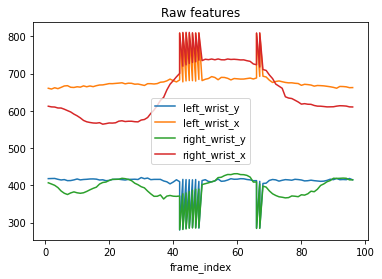

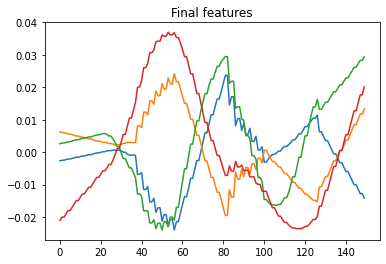

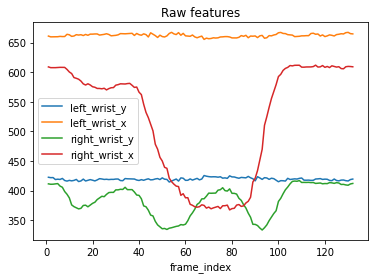

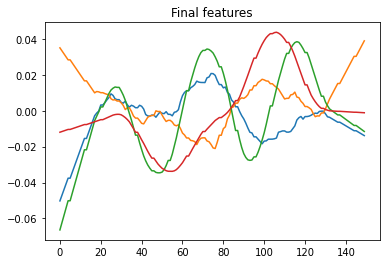

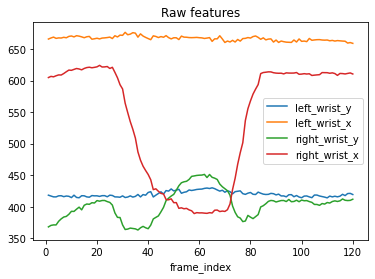

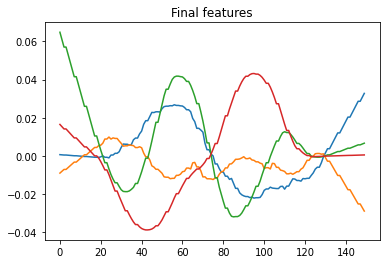

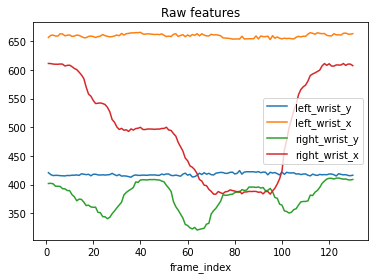

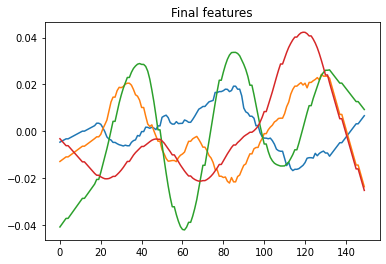

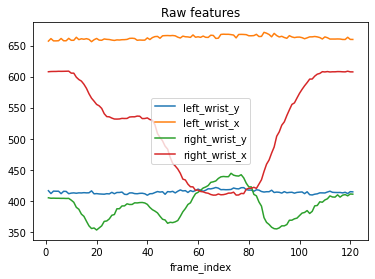

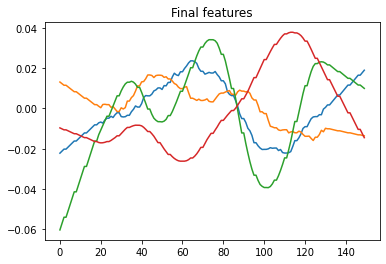

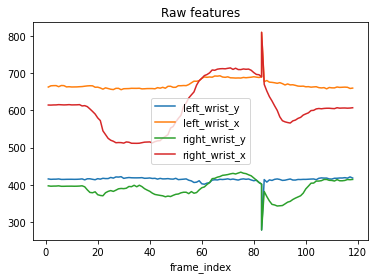

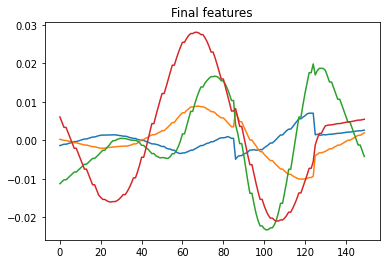

In [25]:
test_fe = ExtractFeatures(test_data_dir, har_cfg_f)
X_test_ind, Labels_test_ind = test_fe.generate_features(draw_plots=True)

In [26]:
len(X_test_ind)

6

In [27]:
Labels_test_ind

array([['vid5'],
       ['vid4'],
       ['vid6'],
       ['vid2'],
       ['vid1'],
       ['vid3']], dtype=object)

In [28]:
# test_set_ind = PredictionDataset(data=X_test_ind)
# test_ind_generator = DataLoader(test_set_ind, batch_size=1, shuffle=False, num_workers=1)
test_set_ind = PredictionDataset(data=X_test_ind)
test_ind_generator = DataLoader(test_set_ind, batch_size=1, shuffle=False, num_workers=1)


In [29]:
def predict(net, data_loader, device="cpu"):

    net.eval()
    preds = []        
    with torch.no_grad():
        for data in data_loader:
            if device == 'cuda':
                data = data.cuda()

            data = data.view(-1, input_channels, seq_length)
            data = Variable(data)
            output = net(data.double())

            pred = output.data.max(1, keepdim=True)[1]

            preds += [LE.inverse_transform(pred.cpu().numpy()[0])]
#                 correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    return np.array(preds)

In [30]:
# def predict(net, data_loader, device="cpu"):

#     net.eval()
#     preds = []
#     with torch.no_grad():
#         for data in data_loader:
#             if device == 'cuda':
#                 data = data.cuda()

#             data = data.view(-1, input_channels, seq_length)
#             data = Variable(data)
#             output = net(data.double())

# #                 pred = output.data.max(1, keepdim=True)[1]

#             pred = torch.round(torch.sigmoid(output)).data
#             preds += [LE.inverse_transform(pred.squeeze(1).cpu().numpy().astype(int))]

#     return preds

In [31]:
device = 'cpu'
cuda=False
if torch.cuda.is_available(): 
    device = 'cuda'
    cuda=True
print(cuda, device)

pred = predict(best_trained_model, test_ind_generator, device) 
print(pred)
# print("Final prediction: {}".format(LE.inverse_transform(pred[0])))
# print("Final prediction: {}".format(pred[0][0]))

True cuda
[['bananas_left']
 ['mandarins_right']
 ['bananas_left']
 ['mandarins_right']
 ['cucumbers_front']
 ['bananas_left']]


In [32]:
matched_preds = [(l[0], p[0]) for l, p in zip(Labels_test_ind, pred)]
print(matched_preds)

[('vid5', 'bananas_left'), ('vid4', 'mandarins_right'), ('vid6', 'bananas_left'), ('vid2', 'mandarins_right'), ('vid1', 'cucumbers_front'), ('vid3', 'bananas_left')]


# Save model, Model config and Label encoder

In [36]:
model_dir = "/home/ur5/sandbox/har_scenario_modeling/models/scenario5" 

# Save Label encoder
import pickle 

LE_f = os.path.join(model_dir, 'LE.pkl')

f = open(LE_f,"wb")
pickle.dump(LE, f)
f.close()

# with open(LE_f, 'w') as f:
#     pickle.dump(LE,f)

print("Label encoder saved to: ", LE_f)


# Save model config
import json 

TCN_cfg = {
    'input_channels' : input_channels,
    'levels' : levels,
    'output_size' : n_classes,
    'best_channel_sizes' : [best_trial.config['num_channels_each_tcn_layer']] * levels,
    'ksize' : ksize  
    
}

TCN_cfg_f = os.path.join(model_dir, 'TCN_cfg.json')

with open(TCN_cfg_f, 'w') as f:
    json.dump(TCN_cfg, f)

print("TCN_cfg saved to: ", TCN_cfg_f)


Label encoder saved to:  /home/ur5/sandbox/har_scenario_modeling/models/scenario5/LE.pkl
TCN_cfg saved to:  /home/ur5/sandbox/har_scenario_modeling/models/scenario5/TCN_cfg.json


In [37]:
model_path = os.path.join(model_dir,"best_tcn_model.pt")
print("Saving: ", model_path)
torch.save(best_trained_model.state_dict(), model_path) #Works the same when I load it back

Saving:  /home/ur5/sandbox/har_scenario_modeling/models/scenario5/best_tcn_model.pt


In [35]:
xxxxxxxxxxx

NameError: name 'xxxxxxxxxxx' is not defined

# Load classifer